# Predicting California Property Close Price (Final Sales Price)

- **Dataset from**: datasets containing historical close price (final sales price) data on real estate properties sourced from CRMLS (California Regional Multiple Listing Service)

- **The project goal**: develop a machine-learning model to predict the close price of a particular property based on its characteristics

## The project steps

**1. Exploratory Data Analysis (EDA)**: understand your data and verify that it doesn't contain errors
   - do as much EDA as you can!
    
**2. Split the data into different sets**: most often the sets are train, validation, and test

**3. Preprocess the data**: ML models only work if X and Y are numbers! Some ML models additionally require each feature to have 0 mean and 1 standard deviation (standardized features)
   - often the original features you get contain strings (for example a gender feature would contain 'male', 'female', 'non-binary', 'unknown') which needs to transformed into numbers
   - often the features are not standardized (e.g., age is between 0 and 100) but it need to be standardized
    
**4. Choose an evaluation metric**: depends on the priorities of the stakeholders
   - often requires quite a bit of thinking and ethical considerations
     
**5. Choose one or more ML techniques**: it is highly recommended that you try multiple models
   - start with simple models like linear or logistic regression
   - try also more complex models like nearest neighbors, support vector machines, random forest, etc.
    
**6. Tune the hyperparameters of your ML models (aka cross-validation)**
   - ML techniques have hyperparameters that you need to optimize to achieve best performance
   - for each ML model, decide which parameters to tune and what values to try
   - loop through each parameter combination
       - train one model for each parameter combination
       - evaluate how well the model performs on the validation set
   - take the parameter combo that gives the best validation score
   - evaluate that model on the test set to report how well the model is expected to perform on previously unseen data
    
**7. Interpret your model**: black boxes are often not useful
   - check if your model uses features that make sense (excellent tool for debugging)
   - often model predictions are not enough, you need to be able to explain how the model arrived to a particular prediction (e.g., in health care)

## Package and dataset


In [4]:
# pip install basemap basemap-data-hires

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from mpl_toolkits.basemap import Basemap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold

In [7]:
data = pd.read_csv('ca_colse_price_prediction_data.csv')

## Exploratory Data Analysis (EDA)

### basic information checking

In [8]:
df = data

In [9]:
df.shape

(50174, 31)

In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50174 entries, 0 to 50173
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flooring                     30165 non-null  object 
 1   ViewYN                       37887 non-null  object 
 2   PoolPrivateYN                41306 non-null  object 
 3   ListingKey                   50174 non-null  int64  
 4   CloseDate                    50174 non-null  object 
 5   ClosePrice                   50174 non-null  float64
 6   Latitude                     50152 non-null  float64
 7   Longitude                    50152 non-null  float64
 8   PropertyType                 50174 non-null  object 
 9   LivingArea                   50117 non-null  float64
 10  ListPrice                    50174 non-null  float64
 11  DaysOnMarket                 50174 non-null  int64  
 12  AssociationFeeFrequency      10169 non-null  object 
 13  AttachedGarageYN

In [11]:
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_data_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percentage
})
print(missing_data_df)

                             Missing Values  Percentage (%)
Flooring                              20009       39.879220
ViewYN                                12287       24.488779
PoolPrivateYN                          8868       17.674493
ListingKey                                0        0.000000
CloseDate                                 0        0.000000
ClosePrice                                0        0.000000
Latitude                                 22        0.043847
Longitude                                22        0.043847
PropertyType                              0        0.000000
LivingArea                               57        0.113605
ListPrice                                 0        0.000000
DaysOnMarket                              0        0.000000
AssociationFeeFrequency               40005       79.732531
AttachedGarageYN                       8445       16.831427
ParkingTotal                            915        1.823654
PropertySubType                         

In [12]:
no_missing = missing_data_df[missing_data_df['Percentage (%)'] == 0].index.tolist()
low_missing = missing_data_df[(missing_data_df['Percentage (%)'] > 0) & (missing_data_df['Percentage (%)'] <= 40)].index.tolist()
high_missing = missing_data_df[missing_data_df['Percentage (%)'] > 40].index.tolist()

print(f"No missing value columns: {no_missing}")
print('------------------------------------------------------------------------------------------------')
print(f"Low missing value columns: {low_missing}")
print('------------------------------------------------------------------------------------------------')
print(f"High missing value columns: {high_missing}")
print('------------------------------------------------------------------------------------------------')


No missing value columns: ['ListingKey', 'CloseDate', 'ClosePrice', 'PropertyType', 'ListPrice', 'DaysOnMarket', 'PropertySubType', 'City', 'BedroomsTotal', 'StateOrProvince']
------------------------------------------------------------------------------------------------
Low missing value columns: ['Flooring', 'ViewYN', 'PoolPrivateYN', 'Latitude', 'Longitude', 'LivingArea', 'AttachedGarageYN', 'ParkingTotal', 'LotSizeAcres', 'YearBuilt', 'BuyerAgencyCompensationType', 'BathroomsTotalInteger', 'FireplaceYN', 'Stories', 'Levels', 'NewConstructionYN', 'GarageSpaces', 'PostalCode']
------------------------------------------------------------------------------------------------
High missing value columns: ['AssociationFeeFrequency', 'MainLevelBedrooms', 'AssociationFee']
------------------------------------------------------------------------------------------------


#### StateOrProvince(drop)

In [13]:
df['StateOrProvince'].value_counts()

,count
StateOrProvince,
CA,50174


In [14]:
# Drop column, totally unique only CA like id
df = df.drop(columns=['StateOrProvince'])

#### Flooring

In [15]:
(df['Flooring'].isnull().sum() / len(df)) * 100

39.87922031330968

In [16]:
print(df['Flooring'].head(3))

0         SeeRemarks,Tile
1               Tile,Wood
2    Carpet,Laminate,Tile
Name: Flooring, dtype: object


In [17]:
print(df['Flooring'].value_counts().head(10))

Flooring
Wood                    4237
Tile,Wood               4048
Carpet,Tile             2992
Laminate                2138
Carpet,Tile,Wood        2090
Laminate,Tile           1491
Tile                    1443
Carpet,Wood             1359
Carpet,Laminate         1280
Carpet,Laminate,Tile    1261
Name: count, dtype: int64


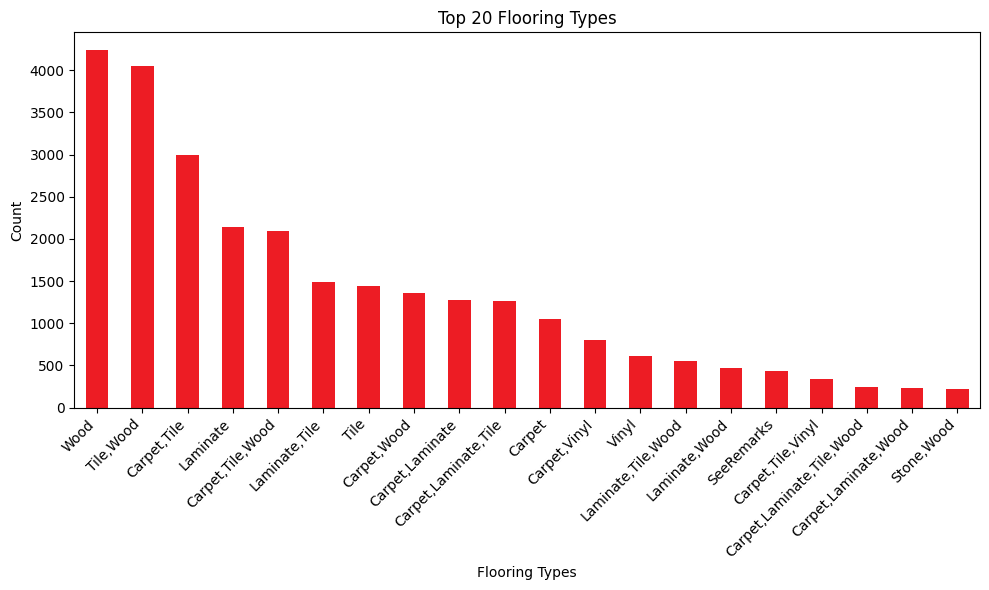

In [18]:
flooring_counts = df['Flooring'].value_counts()
top_20_flooring = flooring_counts.head(20)

plt.figure(figsize=(10, 6))
top_20_flooring.plot(kind='bar', color='#ED1C24')
plt.title('Top 20 Flooring Types')
plt.xlabel('Flooring Types')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 'ViewYN' & 'PoolPrivateYN'

In [19]:
view_missing_percent = (df['ViewYN'].isnull().sum() / len(df)) * 100
pool_missing_percent = (df['PoolPrivateYN'].isnull().sum() / len(df)) * 100

(view_missing_percent, pool_missing_percent)


(24.488779048909795, 17.67449276517718)

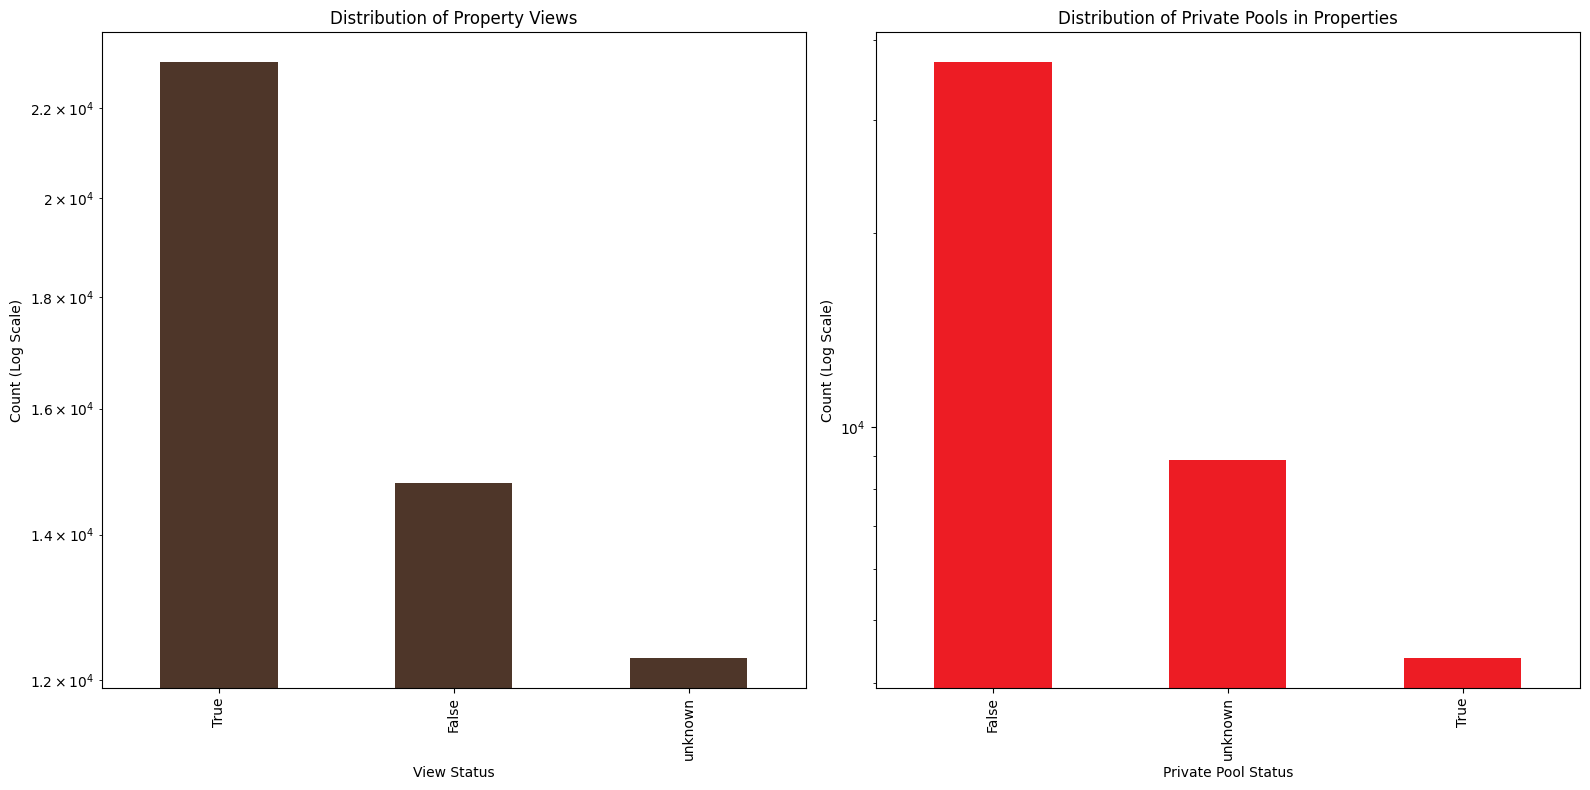

In [20]:
df[['ViewYN', 'PoolPrivateYN']] = df[['ViewYN', 'PoolPrivateYN']].fillna('unknown')

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

df['ViewYN'].value_counts().plot(kind='bar', ax=axs[0], color='#4E3629', logy=True)
axs[0].set_title('Distribution of Property Views')
axs[0].set_xlabel('View Status')
axs[0].set_ylabel('Count (Log Scale)')

df['PoolPrivateYN'].value_counts().plot(kind='bar', ax=axs[1], color='#ED1C24', logy=True)
axs[1].set_title('Distribution of Private Pools in Properties')
axs[1].set_xlabel('Private Pool Status')
axs[1].set_ylabel('Count (Log Scale)')

plt.tight_layout()
plt.show()


####  ListingKey (Drop)

In [21]:
df['ListingKey'].nunique(), df.shape

(50174, (50174, 30))

In [22]:
df.drop(columns=['ListingKey'], inplace=True)

ListingKey are unique, so I drop here

#### CloseDate

In [23]:
(df['CloseDate'].isnull().sum() / len(df)) * 100

0.0

In [24]:
df['CloseDate'].min(), df['CloseDate'].max()

('2022-01-02', '2023-12-31')

In [25]:
jan_2022_data = df[(df['CloseDate'] >= '2022-01-01') & (df['CloseDate'] < '2022-02-01')]

jan_2022_count = jan_2022_data.shape[0]
jan_2022_count

2121

In [26]:
jan_2023_data = df[(df['CloseDate'] >= '2023-01-01') & (df['CloseDate'] < '2023-02-01')]

jan_2023_data = jan_2023_data.shape[0]
jan_2023_data

1302

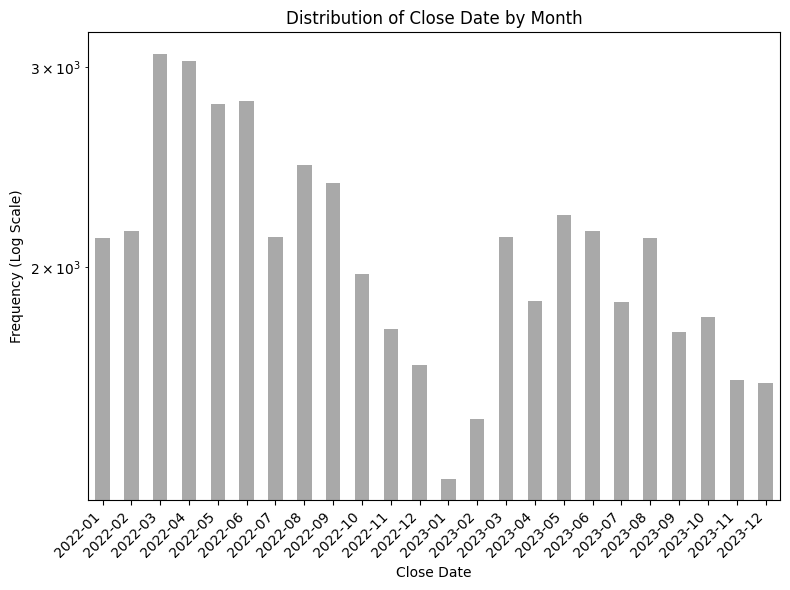

In [27]:
df['CloseDate'] = pd.to_datetime(df['CloseDate'], errors='coerce')
df['CloseDate_Month'] = df['CloseDate'].dt.to_period('M')

plt.figure(figsize=(8, 6))
df['CloseDate_Month'].value_counts().sort_index().plot(kind='bar', color='darkgray', logy=True)
plt.title('Distribution of Close Date by Month')
plt.xlabel('Close Date')
plt.ylabel('Frequency (Log Scale)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### ClosePrice

In [28]:
(df['ClosePrice'].isnull().sum() / len(df)) * 100

0.0

In [29]:
df['ClosePrice'].describe()

,ClosePrice
count,5.017400e+04
mean,1.197168e+06
std,1.410282e+06
min,1.600000e+04
25%,5.800000e+05
50%,8.752500e+05
75%,1.485000e+06
max,1.410000e+08


`ListPrice` is 659000.0, but the `ClosePrice` is 659.0. That is a mistake, so I drop it.

In [30]:
df['ClosePrice'].min()

16000.0

In [31]:
df[df['ClosePrice'] == df['ClosePrice'].min()]

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,PropertyType,LivingArea,ListPrice,...,BedroomsTotal,FireplaceYN,Stories,Levels,MainLevelBedrooms,NewConstructionYN,GarageSpaces,PostalCode,AssociationFee,CloseDate_Month
16128,Vinyl,True,False,2023-09-01,16000.0,33.546182,-117.159311,Residential,2701.0,1580000.0,...,5.0,True,1.0,One,5.0,False,3.0,92563,211.61,2023-09


ClosePrice is 16000.0, and List Price is 1580000.0, which is unreasonable for LivingArea is 2701 sqft

In [32]:
df = df[df['ClosePrice'] != 16000.0]

In [33]:
df['ClosePrice'].max()

141000000.0

In [34]:
df[df['ClosePrice'] == df['ClosePrice'].max()]

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,PropertyType,LivingArea,ListPrice,...,BedroomsTotal,FireplaceYN,Stories,Levels,MainLevelBedrooms,NewConstructionYN,GarageSpaces,PostalCode,AssociationFee,CloseDate_Month
46928,"Carpet,Stone",True,True,2022-03-30,141000000.0,34.088355,-118.451663,Residential,105000.0,295000000.0,...,21.0,True,NaN,NaN,NaN,False,50.0,90077,NaN,2022-03


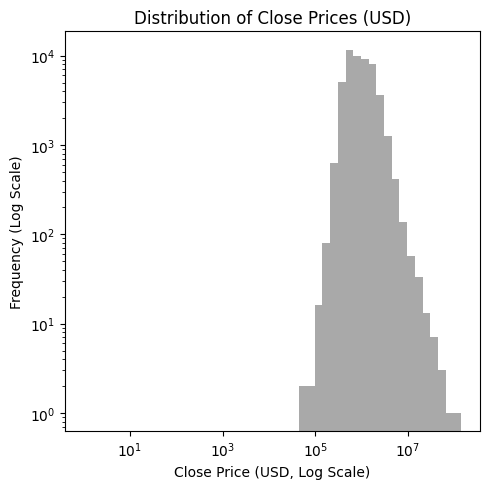

In [35]:
plt.figure(figsize=(5,5))

bins = np.logspace(np.log10(1), np.log10(np.max(df['ClosePrice'])), 50)
df['ClosePrice'].plot.hist(bins=bins, log=True, color='darkgray')

plt.semilogx()
plt.semilogy()
plt.title('Distribution of Close Prices (USD)')
plt.xlabel('Close Price (USD, Log Scale)')
plt.ylabel('Frequency (Log Scale)')
plt.tight_layout()
plt.show()

#### Longitude & Latitude

In [36]:
df['Longitude'].isnull().sum(), df['Latitude'].isnull().sum()

(22, 22)

In [37]:
df.shape

(50173, 30)

In [38]:
california_longitude_range = (-124.26, -114.13)
california_latitude_range = (32.53, 42.00)

In [39]:
df = df[
    ((df['Longitude'] >= california_longitude_range[0]) & (df['Longitude'] <= california_longitude_range[1]) | df['Longitude'].isna()) &
    ((df['Latitude'] >= california_latitude_range[0]) & (df['Latitude'] <= california_latitude_range[1]) | df['Latitude'].isna())
]
df.shape

(50169, 30)

In [40]:
city_name = df['City'].value_counts()
city_name

,count
City,
Los Angeles,10803
San Diego,9942
San Jose,7699
Riverside,4850
Oakland,3969
Menifee,3480
Victorville,3377
Hemet,3026
Murrieta,3023


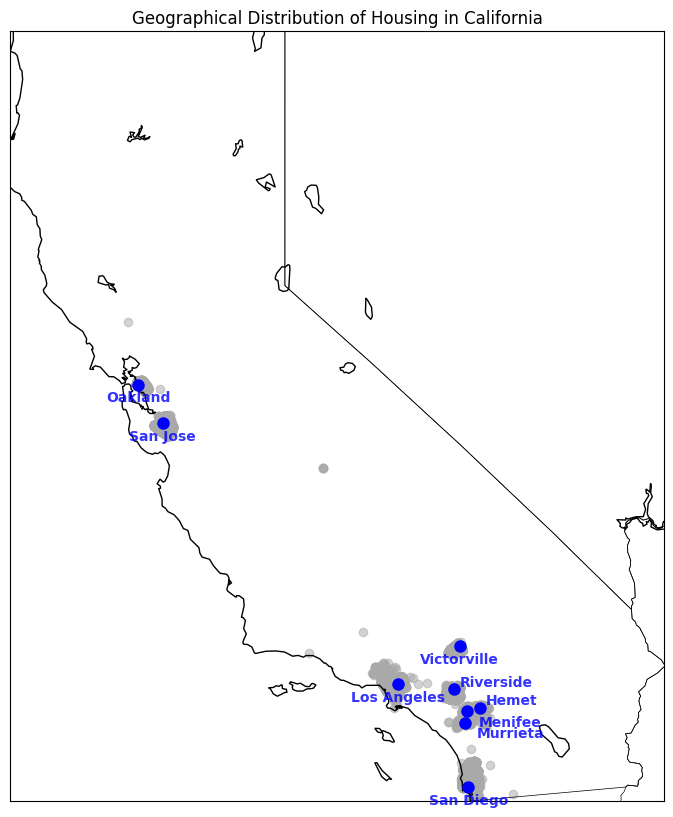

In [41]:
coords = {
    "Los Angeles": (34.052235, -118.243683),
    "San Diego": (32.715736, -117.161087),
    "San Jose": (37.335480, -121.893028),
    "Riverside": (33.980600, -117.375494),
    "Oakland": (37.804363, -122.271111),
    "Menifee": (33.697147, -117.185294),
    "Victorville": (34.536218, -117.292764),
    "Hemet": (33.747520, -116.971968),
    "Murrieta": (33.553914, -117.213923)
}

plt.figure(figsize=(12, 10))
m = Basemap(projection='merc',
            llcrnrlat=32.53, urcrnrlat=42,
            llcrnrlon=-124.26, urcrnrlon=-114.13,
            resolution='i')
m.drawcoastlines()
m.drawcountries()
m.drawstates()

x, y = m(df['Longitude'].values, df['Latitude'].values)
m.scatter(x, y, color='darkgray', alpha=0.5, marker='o')

for city, (lat, lon) in coords.items():
    x, y = m(lon, lat)
    m.plot(x, y, marker='o', color='blue', markersize=8)

    if city in ["Hemet", "Riverside"]:
        plt.text(x + 10000, y, city, fontsize=10, fontweight='bold',
                 ha='left', va='bottom', color='blue', alpha=0.8)
    elif city in ["Murrieta", "Menifee"]:
        plt.text(x + 20000, y - 30000, city, fontsize=10, fontweight='bold',
                 ha='left', va='bottom', color='blue', alpha=0.8)
    else:
        plt.text(x, y - 10000, city, fontsize=10, fontweight='bold',
                 ha='center', va='top', color='blue', alpha=0.8)

plt.title('Geographical Distribution of Housing in California')
plt.show()

#### PropertyType(drop)

Only one PropertyType, so I drop

In [42]:
df['PropertyType'].value_counts()

,count
PropertyType,
Residential,50169


In [43]:
df = df.drop(columns=['PropertyType'])

#### LivingArea

In [44]:
df['LivingArea'].isnull().sum(), df.shape

(57, (50169, 29))

In [45]:
negative_living_area_count = (df['LivingArea'] <= 0).sum()
negative_living_area_count

42

In [46]:
# LivingArea must greater than 1 sq ft
df = df[(df['LivingArea'] > 1) | df['LivingArea'].isna()]
df.shape

(50127, 29)

In [47]:
df['LivingArea'].describe()

,LivingArea
count,50070.000000
mean,1929.691791
std,1093.097417
min,100.000000
25%,1304.000000
50%,1713.000000
75%,2296.000000
max,105000.000000


Can't have a bedroom in a 100 sqft house and their `LotSizeArea` is so big, so I drop it

In [48]:
df[df['LivingArea'] == 100]

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BedroomsTotal,FireplaceYN,Stories,Levels,MainLevelBedrooms,NewConstructionYN,GarageSpaces,PostalCode,AssociationFee,CloseDate_Month
830,NaN,True,False,2022-04-06,2000000.0,33.545359,-117.219989,100.0,1999999.0,249,...,0.0,False,1.0,One,0.0,False,0.0,92562,0.0,2022-04


In [49]:
df = df[df['LivingArea'] != 100]

In [50]:
df['LivingArea'].max()

105000.0

In [51]:
df[df['LivingArea'] == 105000.0]

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BedroomsTotal,FireplaceYN,Stories,Levels,MainLevelBedrooms,NewConstructionYN,GarageSpaces,PostalCode,AssociationFee,CloseDate_Month
46928,"Carpet,Stone",True,True,2022-03-30,141000000.0,34.088355,-118.451663,105000.0,295000000.0,79,...,21.0,True,NaN,NaN,NaN,False,50.0,90077,NaN,2022-03


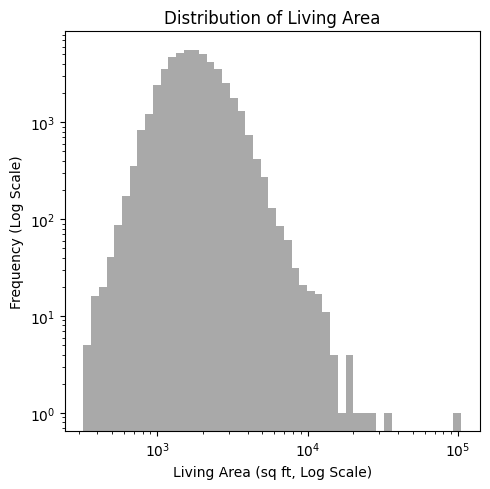

In [52]:
plt.figure(figsize=(5,5))
living_area = df['LivingArea'].dropna()
bins = np.logspace(np.log10(living_area.min()), np.log10(living_area.max()), 50)

plt.hist(living_area, bins=bins, color='darkgray', log=True)


plt.xscale('log')
plt.title('Distribution of Living Area')
plt.xlabel('Living Area (sq ft, Log Scale)')
plt.ylabel('Frequency (Log Scale)')

plt.tight_layout()
plt.show()

#### ListPrice

In [53]:
negative_check = df[df['ListPrice'] < 0]

negative_check

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BedroomsTotal,FireplaceYN,Stories,Levels,MainLevelBedrooms,NewConstructionYN,GarageSpaces,PostalCode,AssociationFee,CloseDate_Month


In [54]:
df['ListPrice'].min()

450.0

This record should be deleted due to the unrealistic OriginalListPrice of 450.0, which does not align with the LivingArea and LotSizeAcres.

In [55]:
df[df['ListPrice'] == 450.0]

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BedroomsTotal,FireplaceYN,Stories,Levels,MainLevelBedrooms,NewConstructionYN,GarageSpaces,PostalCode,AssociationFee,CloseDate_Month
1822,NaN,False,False,2023-10-24,450000.0,33.899174,-117.462269,1000.0,450.0,0,...,3.0,True,1.0,One,3.0,False,2.0,92503,0.0,2023-10


In [56]:
df = df[df['ListPrice'] != 450.0]

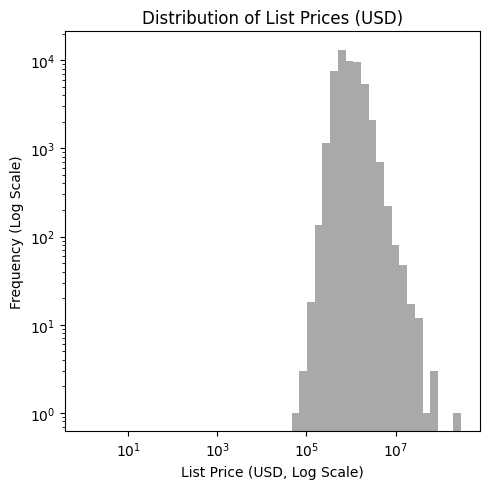

In [57]:
plt.figure(figsize=(5,5))

bins = np.logspace(np.log10(1), np.log10(np.max(df['ListPrice'])), 50)
df['ListPrice'].plot.hist(bins=bins, log=True, color='darkgray')

plt.semilogx()
plt.semilogy()
plt.title('Distribution of List Prices (USD)')
plt.xlabel('List Price (USD, Log Scale)')
plt.ylabel('Frequency (Log Scale)')
plt.tight_layout()
plt.show()

#### DaysOnMarket

In [58]:
negative_days_on_market = df[df['DaysOnMarket'] <= 0]

negative_days_on_market.head(10)

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BedroomsTotal,FireplaceYN,Stories,Levels,MainLevelBedrooms,NewConstructionYN,GarageSpaces,PostalCode,AssociationFee,CloseDate_Month
20,NaN,False,False,2022-05-20,335000.0,34.493929,-117.375512,1650.0,335000.0,0,...,4.0,True,1.0,One,4.0,False,2.0,92392,0.0,2022-05
127,"Carpet,Vinyl",True,False,2022-01-13,350000.0,33.733732,-116.941984,1905.0,350000.0,0,...,3.0,True,1.0,One,3.0,False,2.0,92544,0.0,2022-01
252,NaN,False,False,2022-06-09,675000.0,34.010559,-118.314486,1376.0,679900.0,0,...,3.0,False,1.0,One,3.0,False,1.0,90062,0.0,2022-06
306,NaN,False,False,2022-09-13,455000.0,32.706140,-117.033834,964.0,450000.0,0,...,3.0,False,1.0,One,NaN,NaN,2.0,92114,0.0,2022-09
486,"Tile,Wood",True,False,2022-03-04,1520000.0,34.104226,-118.316633,1677.0,1520000.0,0,...,2.0,False,NaN,NaN,NaN,False,2.0,90028,200.0,2022-03
514,NaN,unknown,False,2022-01-12,625000.0,32.581094,-117.047663,1511.0,625000.0,0,...,4.0,NaN,1.0,One,NaN,NaN,2.0,92154,0.0,2022-01
656,NaN,False,False,2022-03-07,470000.0,34.006783,-118.275730,1168.0,495000.0,0,...,2.0,False,1.0,One,2.0,False,0.0,90037,0.0,2022-03
697,NaN,False,False,2022-07-08,303000.0,33.938971,-118.257077,1070.0,320000.0,0,...,3.0,False,1.0,One,3.0,False,2.0,90002,0.0,2022-07
700,NaN,unknown,False,2022-01-19,390000.0,33.940923,-118.241999,804.0,430000.0,0,...,2.0,NaN,1.0,One,NaN,NaN,0.0,90002,0.0,2022-01
767,Wood,True,False,2022-01-21,350000.0,33.980372,-117.384301,891.0,350000.0,0,...,2.0,False,1.0,One,2.0,False,2.0,92501,0.0,2022-01


In [59]:
df['DaysOnMarket'].isnull().sum()

0

In [60]:
# DaysOnMarket cannot be neg
df = df[(df['DaysOnMarket'] >= 0)]
df.shape

(50111, 29)

In [61]:
df['DaysOnMarket'].describe()

,DaysOnMarket
count,50111.000000
mean,26.090379
std,38.452983
min,0.000000
25%,7.000000
50%,13.000000
75%,30.000000
max,1082.000000


#### AssociationFeeFrequency

In [63]:
df['AssociationFeeFrequency'].fillna('unknown', inplace=True)
df['AssociationFeeFrequency'].value_counts()

<ipython-input-63-00c2c548df0d>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['AssociationFeeFrequency'].fillna('unknown', inplace=True)


,count
AssociationFeeFrequency,
unknown,39948
Monthly,8293
Annually,1558
Quarterly,301
SemiAnnually,11


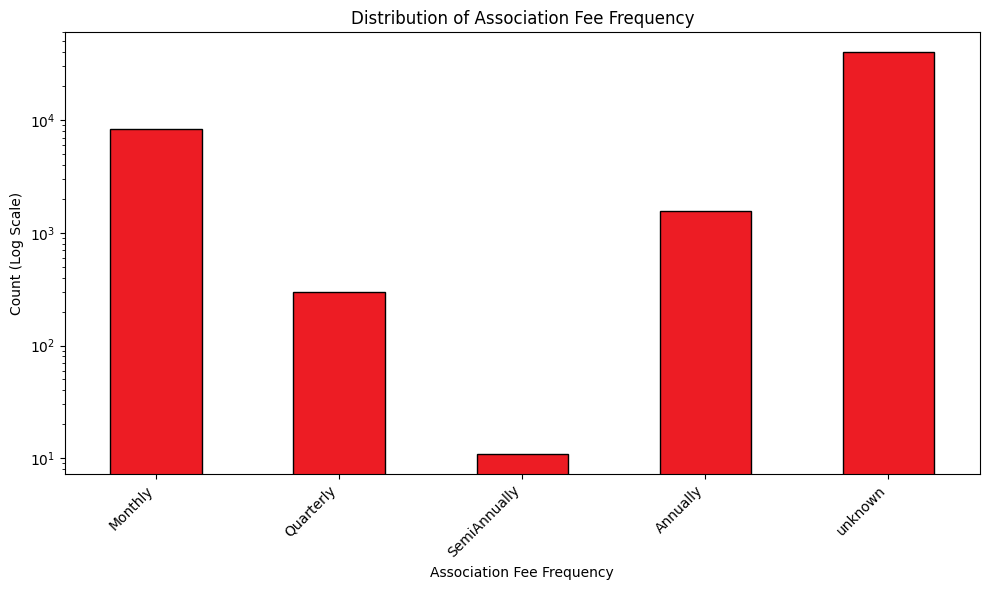

In [64]:
order = ['Monthly', 'Quarterly', 'SemiAnnually', 'Annually', 'unknown']
counts = df['AssociationFeeFrequency'].value_counts().reindex(order)

plt.figure(figsize=(10, 6))
counts.plot(kind='bar', color='#ED1C24', edgecolor='black', logy=True)

plt.title('Distribution of Association Fee Frequency')
plt.xlabel('Association Fee Frequency')
plt.ylabel('Count (Log Scale)')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### AttachedGarageYN

In [65]:
df['AttachedGarageYN'] = df['AttachedGarageYN'].fillna('unknown')

In [66]:
df['AttachedGarageYN'].value_counts()

,count
AttachedGarageYN,
True,33211
False,8488
unknown,8412


In [67]:
unknown_count = df['AttachedGarageYN'].value_counts().get('unknown', 0)
total_count = df['AttachedGarageYN'].shape[0]
unknown_percentage = (unknown_count / total_count) * 100

unknown_percentage

16.786733451737142

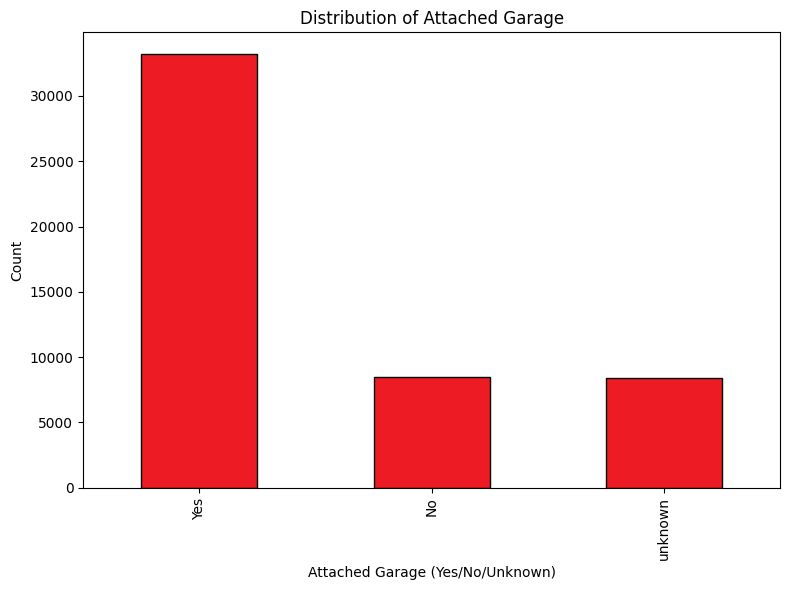

In [68]:
df['AttachedGarageYN'] = df['AttachedGarageYN'].map({True: 'Yes', False: 'No', 'unknown': 'unknown'})

plt.figure(figsize=(8, 6))
df['AttachedGarageYN'].value_counts().plot(kind='bar', color='#ED1C24', edgecolor='black')
plt.title('Distribution of Attached Garage')
plt.xlabel('Attached Garage (Yes/No/Unknown)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### ParkingTotal

In [69]:
df['ParkingTotal'].describe()

,ParkingTotal
count,49197.000000
mean,2.858269
std,18.673068
min,-34.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,2853.000000


In [70]:
# ParkingTotal cannot be neg
df = df[(df['ParkingTotal'] >= 0) | (df['ParkingTotal'].isna())]

In [71]:
df['ParkingTotal'].describe()

,ParkingTotal
count,49191.000000
mean,2.859898
std,18.673105
min,0.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,2853.000000


In [72]:
df[df['ParkingTotal'] == 2853.0]

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BedroomsTotal,FireplaceYN,Stories,Levels,MainLevelBedrooms,NewConstructionYN,GarageSpaces,PostalCode,AssociationFee,CloseDate_Month
40941,"Carpet,Laminate,Tile",True,False,2022-06-01,550000.0,33.742036,-116.911725,1976.0,547500.0,46,...,4.0,True,2.0,Two,0.0,False,3.0,92544,0.0,2022-06


A property with 0.21 LotSizeAcres cannot have 2,853 parking spaces, indicating a data error or anomaly.



In [73]:
df = df.drop(df[(df['ParkingTotal'] == 2853.0)].index)

This record contains unrealistic values, such as 2,400 parking spaces and 10.0 LotSizeAcres, which do not align with a LivingArea of 4,600 sqft.

In [74]:
df[df['ParkingTotal'] == 1824.0]

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BedroomsTotal,FireplaceYN,Stories,Levels,MainLevelBedrooms,NewConstructionYN,GarageSpaces,PostalCode,AssociationFee,CloseDate_Month
45986,NaN,unknown,False,2022-02-16,770000.0,32.577395,-117.073112,1342.0,769900.0,7,...,4.0,NaN,1.0,One,NaN,NaN,NaN,92154,0.0,2022-02


This record contains unrealistic values, such as 2,021 parking spaces on a 0.1705-acre lot, indicating a data error.

In [75]:
df = df.drop(df[(df['ParkingTotal'] == 1824.0)].index)

A single-family residence cannot have more than 1,000 parking spaces.

In [76]:
df.shape

(50103, 29)

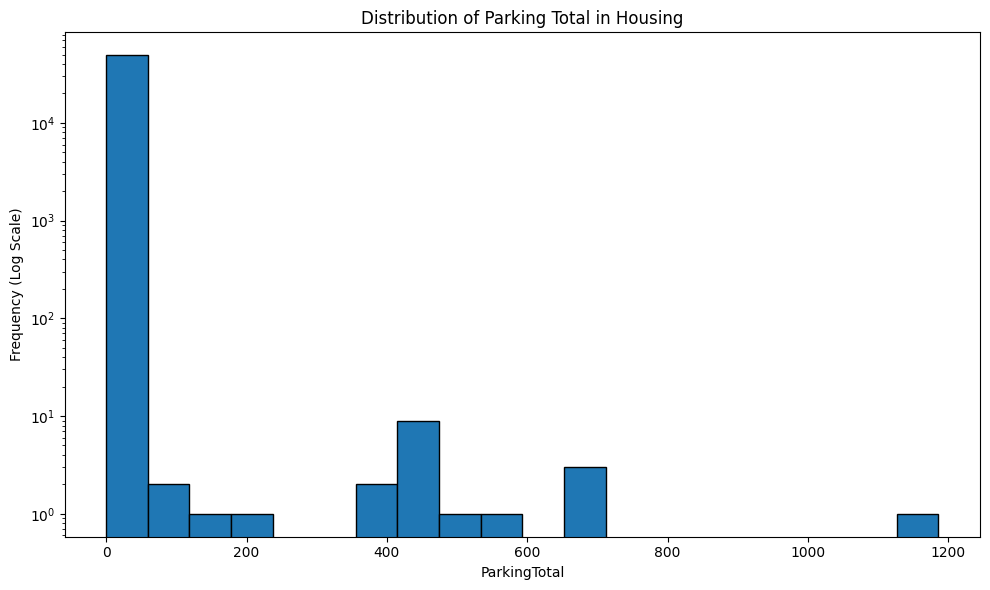

In [77]:
plt.figure(figsize=(10, 6))
plt.hist(df['ParkingTotal'], bins=20, edgecolor='black')
plt.yscale('log')
plt.xlabel('ParkingTotal')
plt.ylabel('Frequency (Log Scale)')
plt.title('Distribution of Parking Total in Housing')
plt.tight_layout()
plt.show()

#### PropertySubType(drop)

In [78]:
df['PropertySubType'] = df['PropertySubType'].fillna('unknown')

In [79]:
df['PropertySubType'].value_counts()

,count
PropertySubType,
SingleFamilyResidence,50103


Drop column, totally unique like id

In [80]:
df.drop(columns=['PropertySubType'], inplace=True)

#### LotSizeAcres

In [81]:
df['LotSizeAcres'].describe()

,LotSizeAcres
count,47982.000000
mean,4.494087
std,456.305323
min,0.000000
25%,0.123300
50%,0.152400
75%,0.190000
max,91040.000000


I am filtering the data to include only properties with a LotSizeAcres below 1,000, as any value above this threshold is unrealistic for a single-family residence and likely represents a data error or anomaly.

In [82]:
df.shape

(50103, 28)

In [83]:
df = df[(df['LotSizeAcres'] < 1000) & (df['LotSizeAcres'] > 0) | (df['LotSizeAcres'].isna())]

In [84]:
df.shape

(50054, 28)

In [85]:
df['LotSizeAcres'].describe()

,LotSizeAcres
count,47933.000000
mean,0.262288
std,1.083612
min,0.000200
25%,0.123400
50%,0.152500
75%,0.190000
max,82.170000


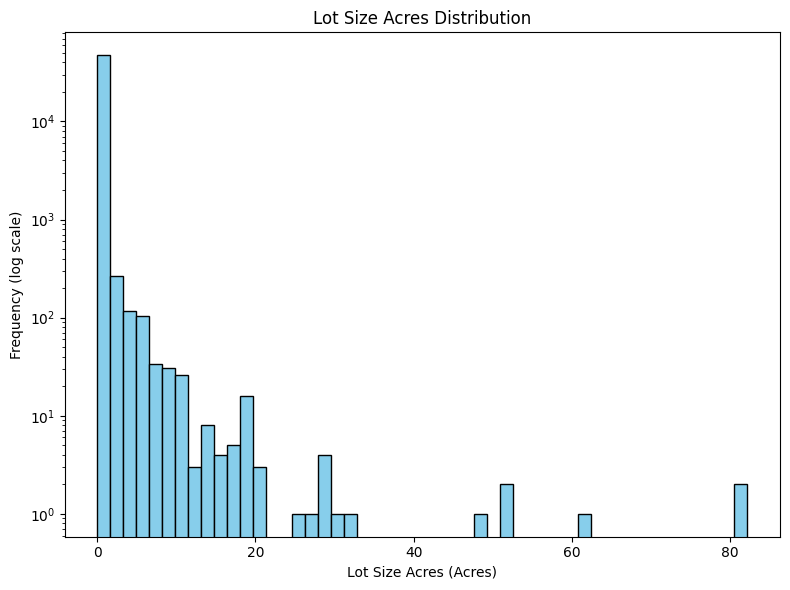

In [86]:
lot_size_acres = df['LotSizeAcres'].dropna()

plt.figure(figsize=(8, 6))
plt.hist(lot_size_acres, bins=50, color='skyblue', edgecolor='black')
plt.yscale('log')
plt.title('Lot Size Acres Distribution')
plt.xlabel('Lot Size Acres (Acres)')
plt.ylabel('Frequency (log scale)')
plt.tight_layout()
plt.show()

#### YearBuilt

In [87]:
df['YearBuilt'].describe()

,YearBuilt
count,49989.000000
mean,1968.666287
std,31.569769
min,1850.000000
25%,1947.000000
50%,1968.000000
75%,1995.000000
max,2024.000000


In [88]:
df['YearBuilt'].isnull().sum()

65

In [89]:
df[df['YearBuilt'] == 1850]

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BedroomsTotal,FireplaceYN,Stories,Levels,MainLevelBedrooms,NewConstructionYN,GarageSpaces,PostalCode,AssociationFee,CloseDate_Month
39161,NaN,True,unknown,2022-07-22,1378888.0,37.36843,-121.79983,896.0,1488888.0,10,...,2.0,True,NaN,NaN,NaN,False,0.0,95127,NaN,2022-07


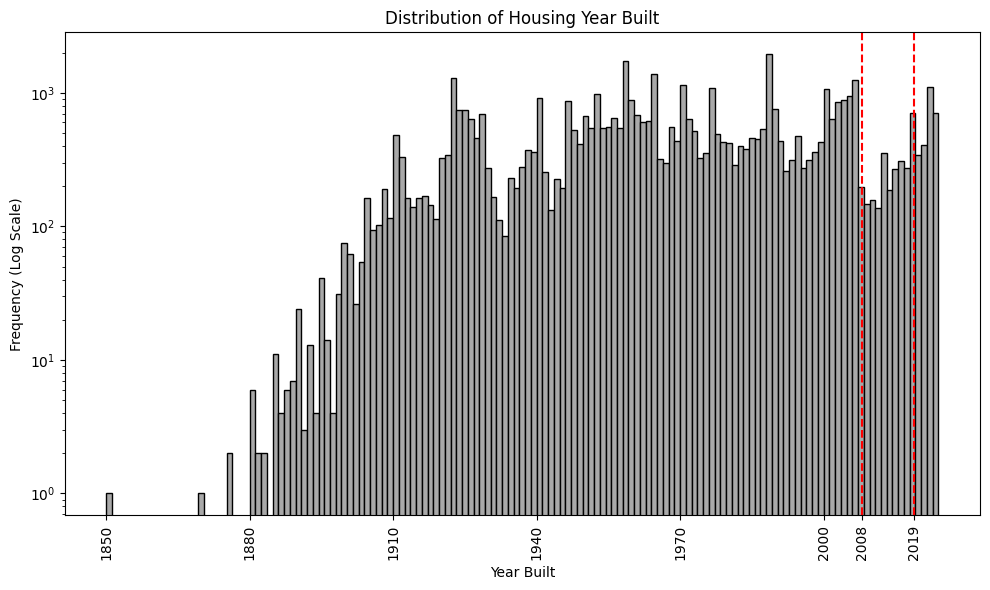

In [90]:
plt.figure(figsize=(10, 6))

df['YearBuilt'].dropna().astype(int).plot(kind='hist', bins=df['YearBuilt'].nunique(),
                                          color='darkgrey', edgecolor='black', log=True)
plt.axvline(2019, color='red', linestyle='--', linewidth=1.5, label='Year 2019')
plt.axvline(2008, color='red', linestyle='--', linewidth=1.5, label='Year 2008')

xticks = list(range(1850, 2025, 30)) + [2008, 2019]
plt.xticks(xticks, rotation=90)

plt.title('Distribution of Housing Year Built')
plt.xlabel('Year Built')
plt.ylabel('Frequency (Log Scale)')
plt.tight_layout()
plt.show()


#### BuyerAgencyCompensationType

In [91]:
df['BuyerAgencyCompensationType'] = df['BuyerAgencyCompensationType'].fillna('unknown')

In [92]:
df['BuyerAgencyCompensationType'].value_counts()

,count
BuyerAgencyCompensationType,
Item1,49674
Item,367
SeeRemarks,12
unknown,1


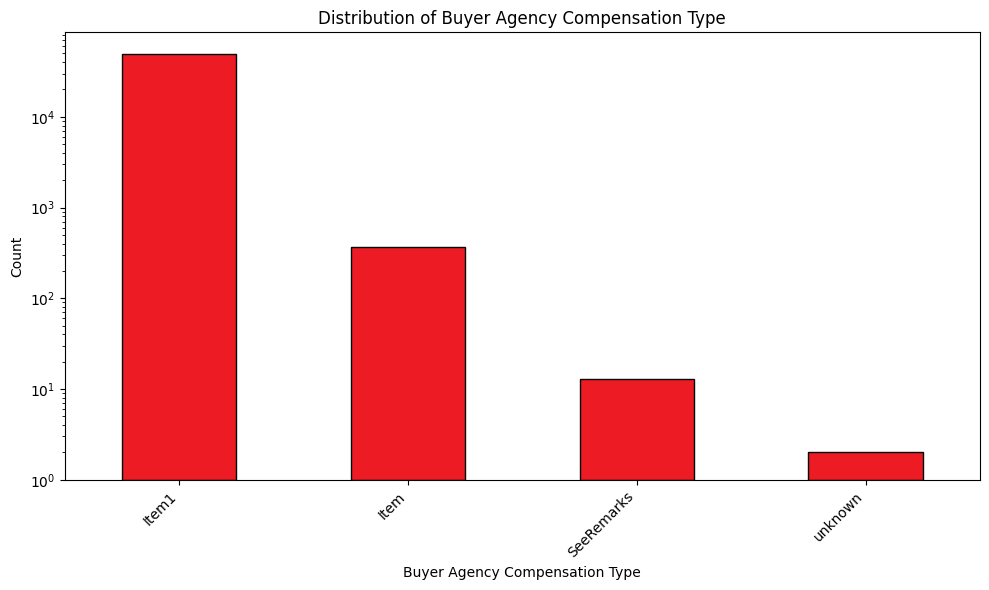

In [93]:
plt.figure(figsize=(10, 6))
df['BuyerAgencyCompensationType'].value_counts().plot(kind='bar', color='#ED1C24', edgecolor='black', log = True)
plt.title('Distribution of Buyer Agency Compensation Type')
plt.xlabel('Buyer Agency Compensation Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### BathroomsTotalInteger

In [94]:
df['BathroomsTotalInteger'].isnull().sum(),df.shape[0]

(14, 50054)

In [95]:
df['BathroomsTotalInteger'].describe()

,BathroomsTotalInteger
count,50040.000000
mean,2.496363
std,1.088294
min,0.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,49.000000


In [96]:
filtered_df = df[df['BathroomsTotalInteger'].isin([49.0])]

filtered_df

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BedroomsTotal,FireplaceYN,Stories,Levels,MainLevelBedrooms,NewConstructionYN,GarageSpaces,PostalCode,AssociationFee,CloseDate_Month
46928,"Carpet,Stone",True,True,2022-03-30,141000000.0,34.088355,-118.451663,105000.0,295000000.0,79,...,21.0,True,NaN,NaN,NaN,False,50.0,90077,NaN,2022-03


In [97]:
filtered_df = df[df['BathroomsTotalInteger'].isin([0])]

filtered_df.shape

(12, 28)

In [98]:
df.shape

(50054, 28)

In [99]:
# It's almost impossible for a residents house have 0 bathrooms
df = df[~df['BathroomsTotalInteger'].isin([0])]

df.shape

(50042, 28)

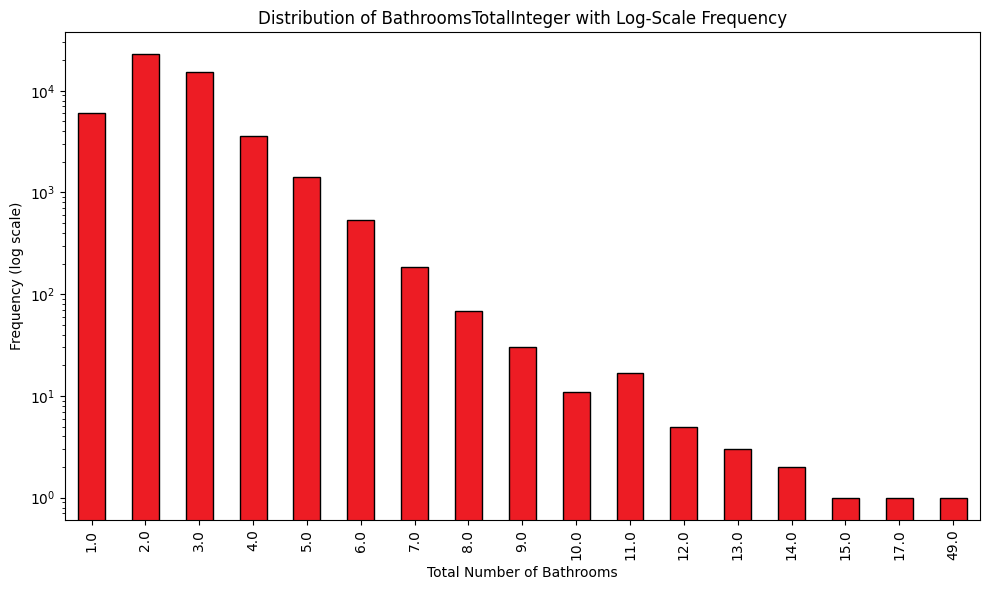

In [100]:
bathrooms_counts = df['BathroomsTotalInteger'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bathrooms_counts.plot(kind='bar',  color='#ED1C24', edgecolor='black', logy=True)
plt.title('Distribution of BathroomsTotalInteger with Log-Scale Frequency')
plt.xlabel('Total Number of Bathrooms')
plt.ylabel('Frequency (log scale)')
plt.tight_layout()
plt.show()

#### City

In [101]:
df['City'].value_counts()

,count
City,
Los Angeles,10748
San Diego,9908
San Jose,7693
Riverside,4843
Oakland,3957
Menifee,3478
Victorville,3372
Hemet,3022
Murrieta,3021


In [102]:
df['City'] = df['City'].fillna('unknown')

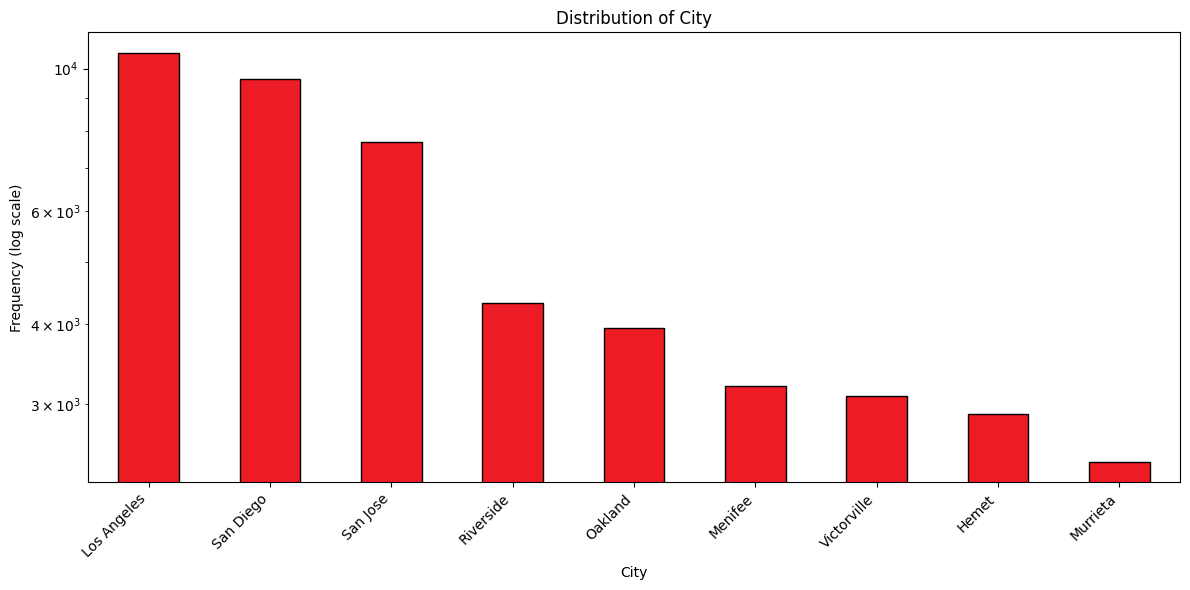

In [183]:
city_counts = df['City'].value_counts().head(25)

plt.figure(figsize=(12, 6))
city_counts.plot(kind='bar', color='#ED1C24', edgecolor='black', logy=True)
plt.title('Distribution of City')
plt.xlabel('City')
plt.ylabel('Frequency (log scale)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### BedroomsTotal

In [104]:
df['BedroomsTotal'].describe()

,BedroomsTotal
count,50042.000000
mean,3.418289
std,0.977478
min,0.000000
25%,3.000000
50%,3.000000
75%,4.000000
max,21.000000


In [105]:
df['BedroomsTotal'].describe()

,BedroomsTotal
count,50042.000000
mean,3.418289
std,0.977478
min,0.000000
25%,3.000000
50%,3.000000
75%,4.000000
max,21.000000


In [106]:
df = df[df['BedroomsTotal'] != 0]

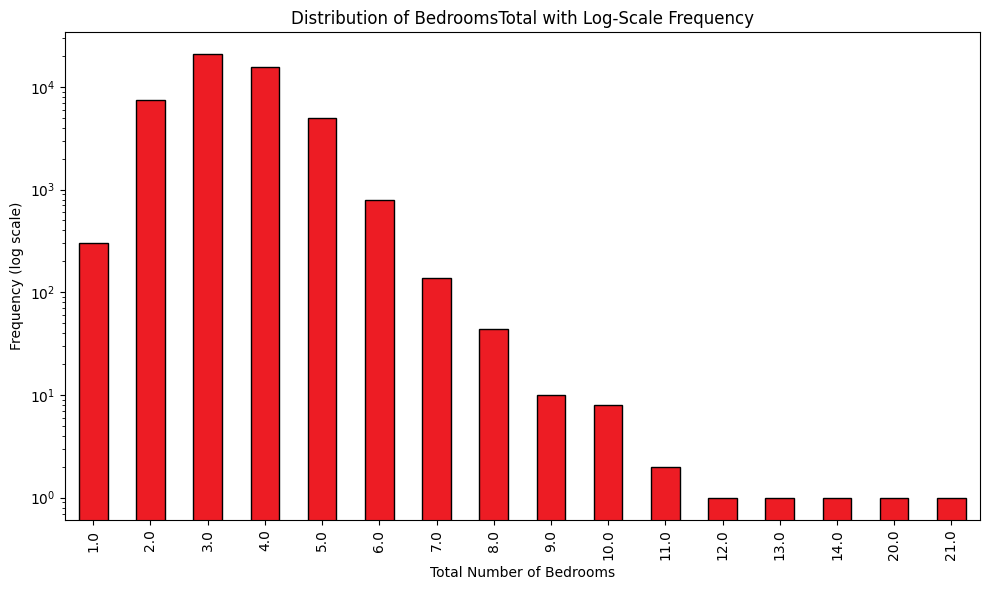

In [107]:
bedrooms_counts = df['BedroomsTotal'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bedrooms_counts.plot(kind='bar', color='#ED1C24', edgecolor='black', logy=True)
plt.title('Distribution of BedroomsTotal with Log-Scale Frequency')
plt.xlabel('Total Number of Bedrooms')
plt.ylabel('Frequency (log scale)')
plt.tight_layout()
plt.show()

#### FireplaceYN

In [108]:
df['FireplaceYN'] = df['FireplaceYN'].fillna('unknown')
fireplace_counts = df['FireplaceYN'].value_counts()
fireplace_counts

,count
FireplaceYN,
True,34004
False,12563
unknown,3471


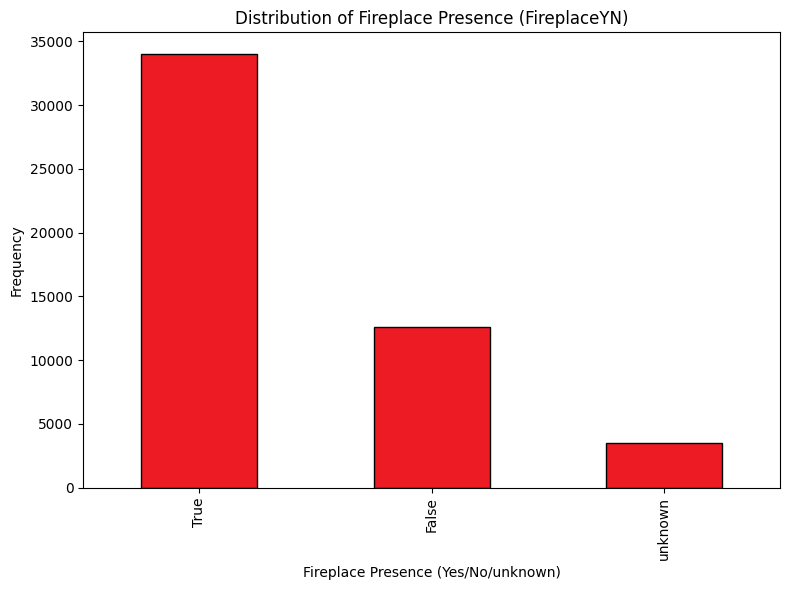

In [109]:
plt.figure(figsize=(8, 6))
fireplace_counts.plot(kind='bar', color='#ED1C24', edgecolor='black')
plt.title('Distribution of Fireplace Presence (FireplaceYN)')
plt.xlabel('Fireplace Presence (Yes/No/unknown)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

#### Stories

In [110]:
df['Stories'].describe()

,Stories
count,36252.000000
mean,1.355125
std,0.478558
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


#### Levels

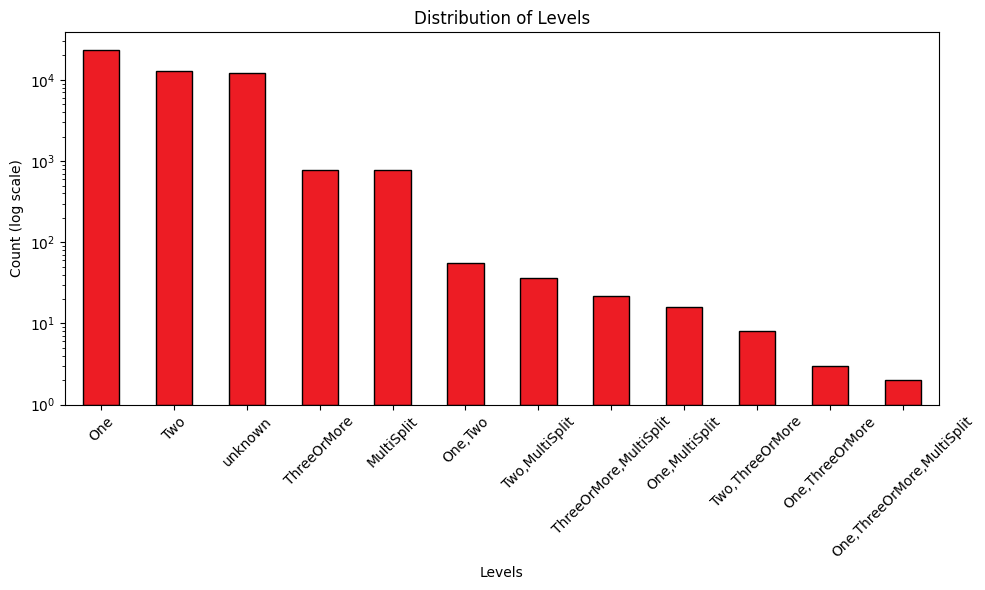

In [112]:
df['Levels'] = df['Levels'].fillna('unknown')

plt.figure(figsize=(10,6))
df['Levels'].value_counts().plot(kind='bar',  color='#ED1C24', edgecolor='black', log = True)
plt.title('Distribution of Levels')
plt.xlabel('Levels')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### MainLevelBedrooms

In [113]:
df = df[df['MainLevelBedrooms'] != 0]

In [114]:
df.shape

(47793, 28)

In [115]:
df['MainLevelBedrooms'].describe()

,MainLevelBedrooms
count,20016.000000
mean,2.558953
std,1.208357
min,1.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,53.000000


#### NewConstructionYN

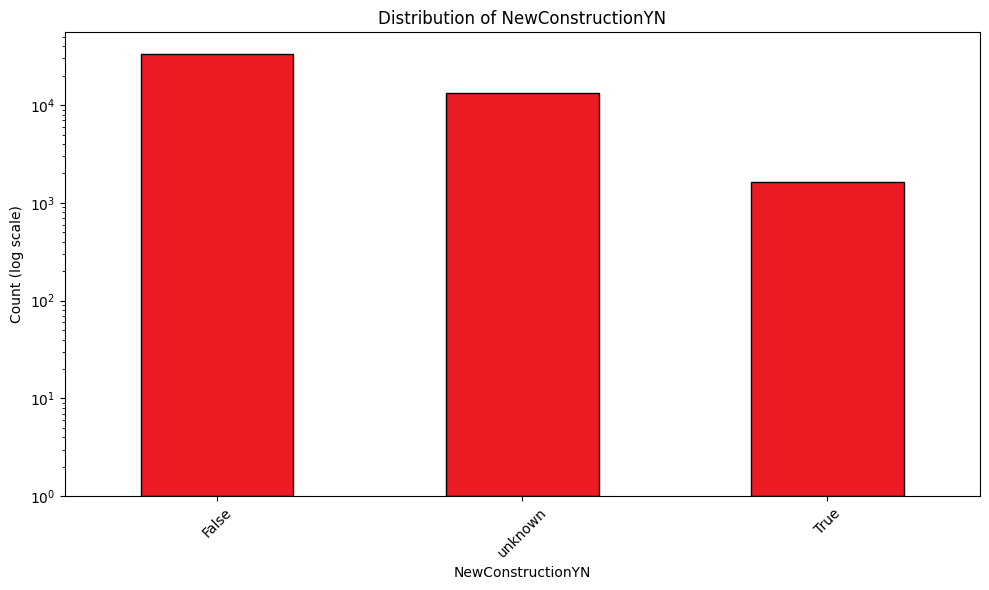

In [117]:
df['NewConstructionYN'] = df['NewConstructionYN'].fillna('unknown')

plt.figure(figsize=(10,6))
df['NewConstructionYN'].value_counts().plot(kind='bar',  color='#ED1C24', edgecolor='black', log = True)
plt.title('Distribution of NewConstructionYN')
plt.xlabel('NewConstructionYN')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### GarageSpaces

In [118]:
df['GarageSpaces'].describe()

,GarageSpaces
count,43604.000000
mean,1.849733
std,2.861962
min,0.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,400.000000


In [119]:
df = df[df['GarageSpaces'] != 400]

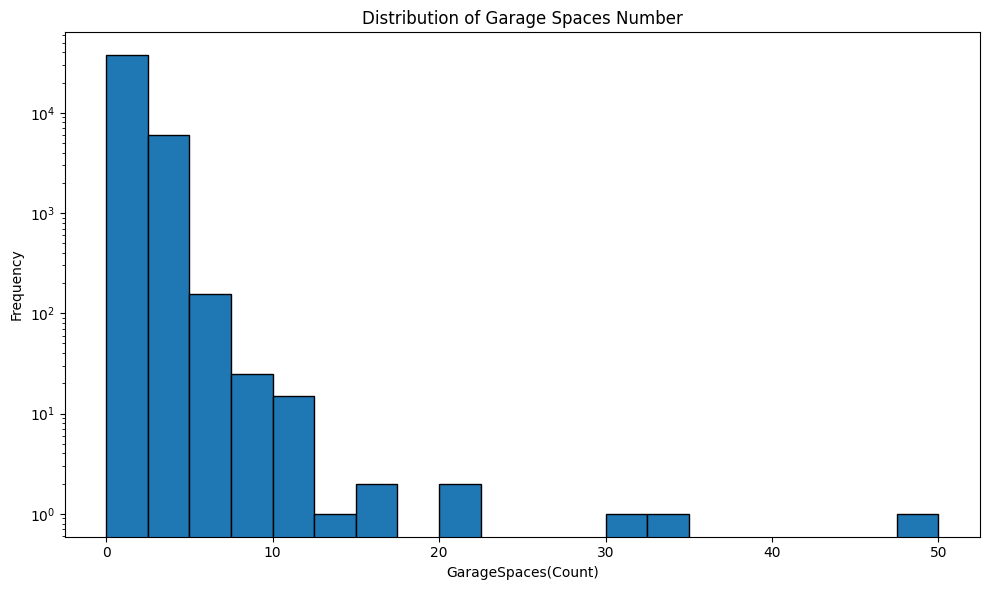

In [185]:
plt.figure(figsize=(10, 6))
plt.hist(df['GarageSpaces'].dropna(), bins=20, edgecolor='black', log=True)
plt.xlabel('GarageSpaces(Count)')
plt.ylabel('Frequency')
plt.title('Distribution of Garage Spaces Number')
plt.tight_layout()
plt.show()

#### PostalCode

In [121]:
df['PostalCode'].value_counts()

,count
PostalCode,
92584,1508
92392,1285
92562,1273
92563,1167
92545,1140
...,...
94067,1
94605-3658,1
95129-3843,1


In [122]:
df.shape

(47791, 28)

In [123]:
df['PostalCode'] = df['PostalCode'].astype(str).str[:5]
df['PostalCode'] = pd.to_numeric(df['PostalCode'], errors='coerce')
df = df[(df['PostalCode'] >= 90001) & (df['PostalCode'] <= 96162) | df['PostalCode'].isna()]
df['PostalCode'] = df['PostalCode'].astype('Int64')

<ipython-input-123-910bffc04012>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PostalCode'] = df['PostalCode'].astype('Int64')


In [124]:
df['PostalCode'].value_counts()

,count
PostalCode,
92584,1508
92392,1285
92562,1273
92563,1167
92545,1140
...,...
91356,1
91367,1
91304,1


In [125]:
df.shape

(47787, 28)

#### AssociationFee

In [126]:
 df[df['AssociationFee'] < 0]

,Flooring,ViewYN,PoolPrivateYN,CloseDate,ClosePrice,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,...,BedroomsTotal,FireplaceYN,Stories,Levels,MainLevelBedrooms,NewConstructionYN,GarageSpaces,PostalCode,AssociationFee,CloseDate_Month


In [127]:
df['AssociationFee'].describe()

,AssociationFee
count,27146.000000
mean,66.023395
std,164.314911
min,0.000000
25%,0.000000
50%,0.000000
75%,80.000000
max,6600.000000


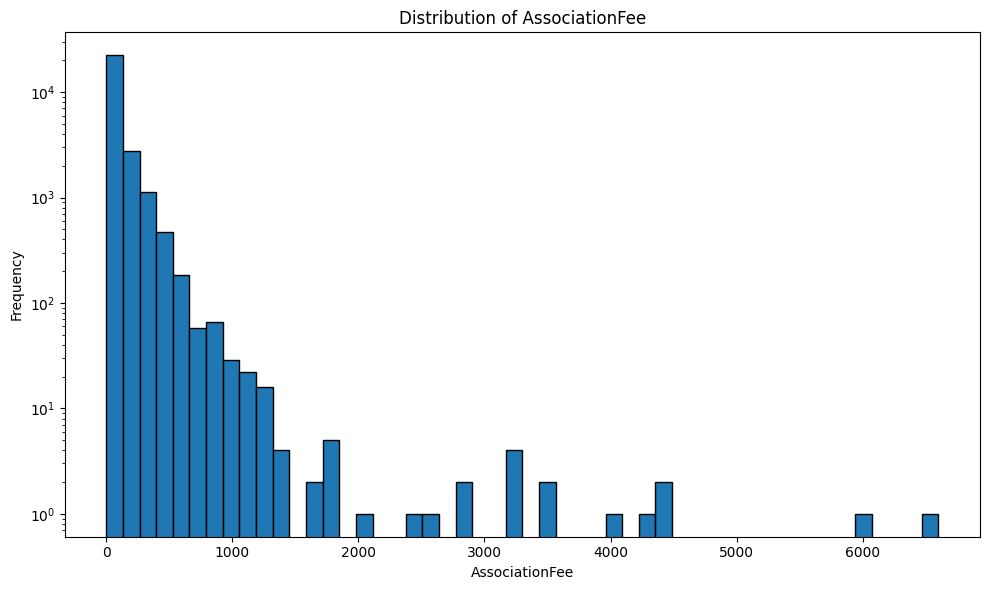

In [128]:
plt.figure(figsize=(10, 6))
plt.hist(df['AssociationFee'].dropna(), bins=50, edgecolor='black', log=True)
plt.xlabel('AssociationFee')
plt.ylabel('Frequency')
plt.title('Distribution of AssociationFee')
plt.tight_layout()
plt.show()

### Cross Plot

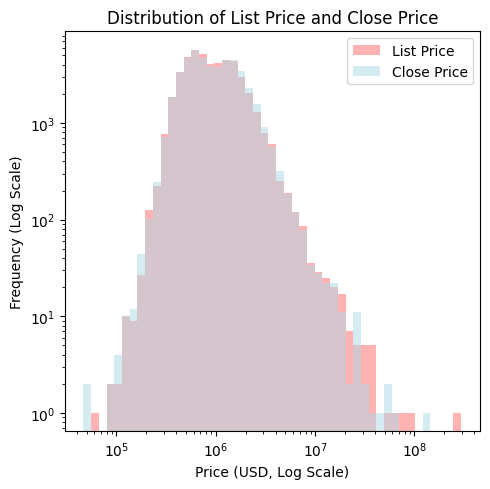

In [129]:
list_price = df['ListPrice'].dropna()
close_price = df['ClosePrice'].dropna()

min_val = min(list_price.min(), close_price.min())
max_val = max(list_price.max(), close_price.max())
bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

plt.figure(figsize=(5, 5))
plt.hist(list_price, bins=bins, color='red', log=True, alpha=0.3, label='List Price')
plt.hist(close_price, bins=bins, color='lightblue', log=True, alpha=0.5, label='Close Price')

plt.xscale('log')
plt.yscale('log')
plt.title('Distribution of List Price and Close Price')
plt.xlabel('Price (USD, Log Scale)')
plt.ylabel('Frequency (Log Scale)')
plt.legend()

plt.tight_layout()
plt.show()


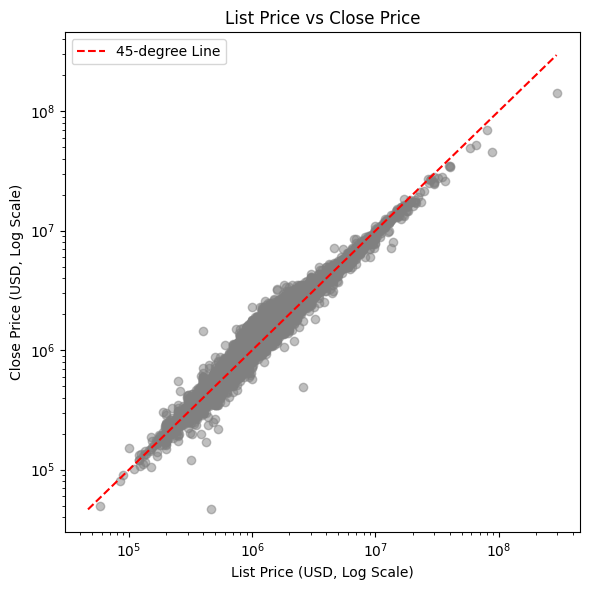

In [130]:
plt.figure(figsize=(6, 6))
plt.scatter(list_price, close_price, alpha=0.5, color='gray')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('List Price (USD, Log Scale)')
plt.ylabel('Close Price (USD, Log Scale)')
plt.title('List Price vs Close Price')

max_val = max(max(list_price), max(close_price))
min_val = min(min(list_price), min(close_price))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='45-degree Line')
plt.legend()

plt.tight_layout()
plt.show()

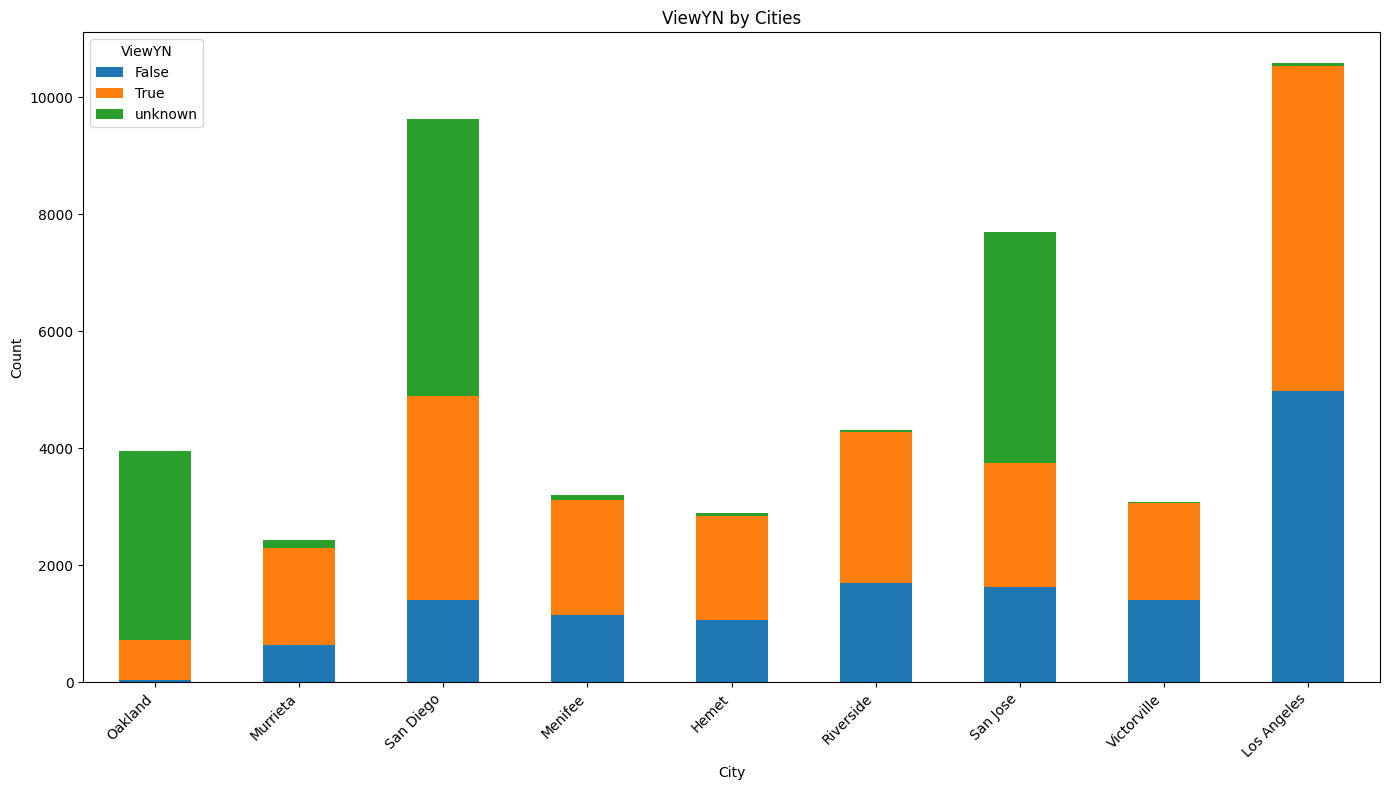

In [134]:
filtered_city_df = df[df['City'] != 'unknown']
top_20_cities = filtered_city_df['City'].value_counts().nlargest(20).index

top_20_city_df = filtered_city_df[filtered_city_df['City'].isin(top_20_cities)]

view_proportion = top_20_city_df.groupby(['City', 'ViewYN']).size().unstack(fill_value=0)
view_proportion['True_Proportion'] = view_proportion[True] / (view_proportion[True] + view_proportion[False])
sorted_cities = view_proportion.sort_values(by='True_Proportion', ascending=False).index

view_count = top_20_city_df.groupby(['City', 'ViewYN']).size().unstack(fill_value=0)
sorted_view_count = view_count.loc[sorted_cities]

sorted_view_count.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.xlabel('City')
plt.ylabel('Count')
plt.title('ViewYN by Cities')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

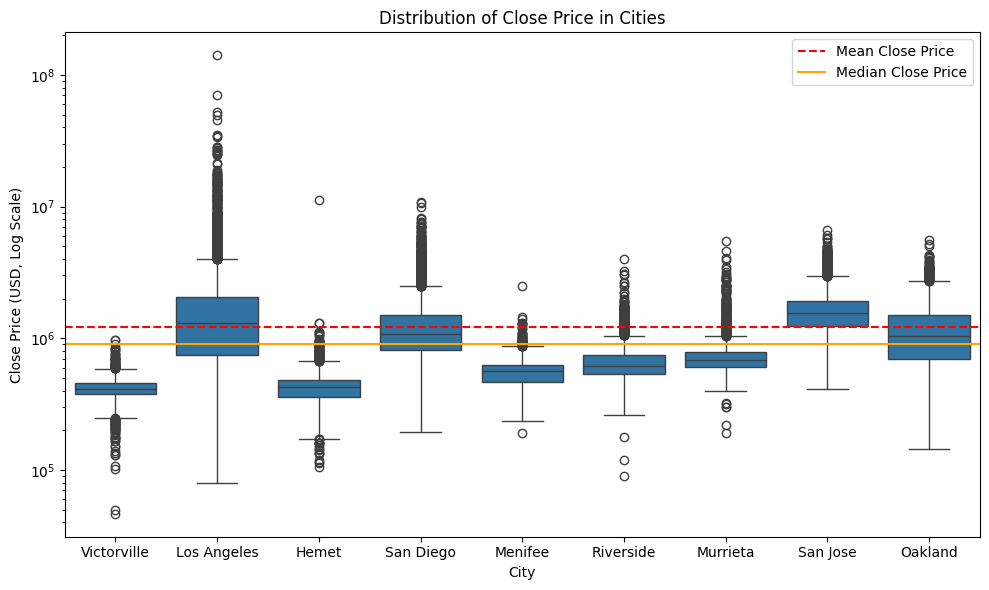

In [135]:
mean_close_price = df['ClosePrice'].mean()
median_close_price = df['ClosePrice'].median()

plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x='City', y='ClosePrice')
plt.yscale('log')
plt.axhline(mean_close_price, color='red', linestyle='--', label='Mean Close Price')
plt.axhline(median_close_price, color='orange', linestyle='-', label='Median Close Price')
plt.title('Distribution of Close Price in Cities')
plt.xlabel('City')
plt.ylabel('Close Price (USD, Log Scale)')
plt.legend()

plt.tight_layout()
plt.show()

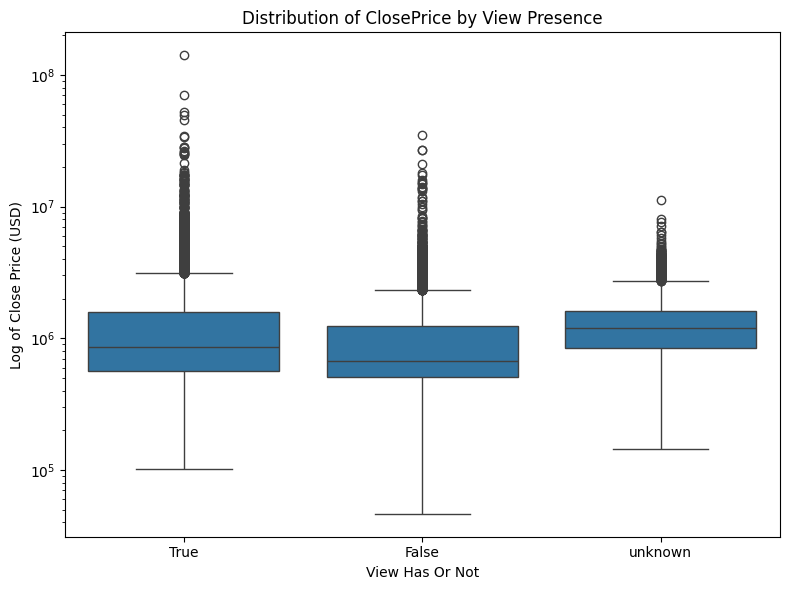

In [136]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='ViewYN', y='ClosePrice')
plt.yscale('log')
plt.title('Distribution of ClosePrice by View Presence')
plt.xlabel('View Has Or Not')
plt.ylabel('Log of Close Price (USD)')
plt.tight_layout()
plt.show()

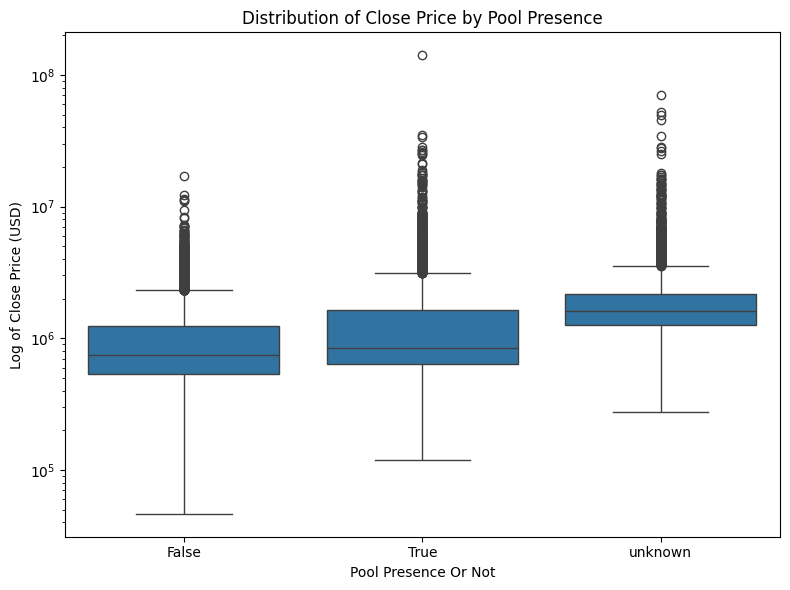

In [137]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='PoolPrivateYN', y='ClosePrice')
plt.yscale('log')
plt.title('Distribution of Close Price by Pool Presence')
plt.xlabel('Pool Presence Or Not')
plt.ylabel('Log of Close Price (USD)')
plt.tight_layout()
plt.show()

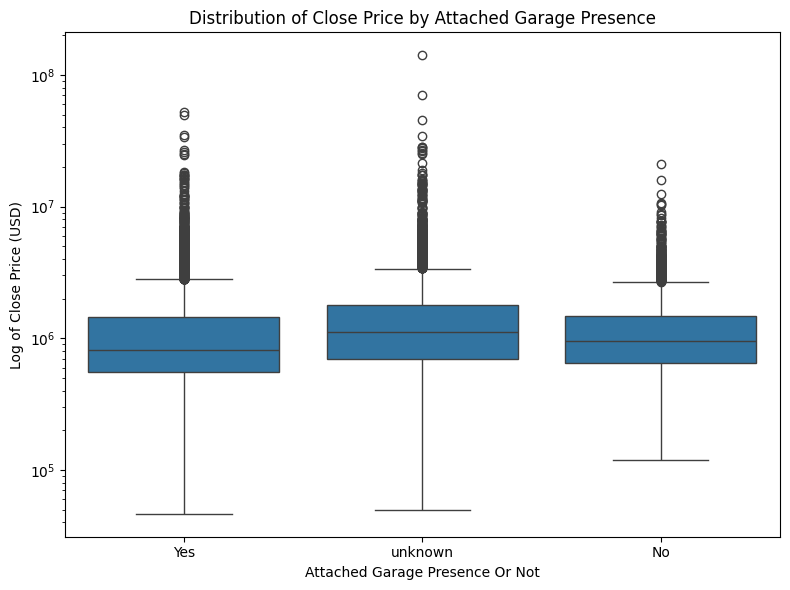

In [138]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='AttachedGarageYN', y='ClosePrice')
plt.yscale('log')
plt.title('Distribution of Close Price by Attached Garage Presence')
plt.xlabel('Attached Garage Presence Or Not')
plt.ylabel('Log of Close Price (USD)')
plt.tight_layout()
plt.show()

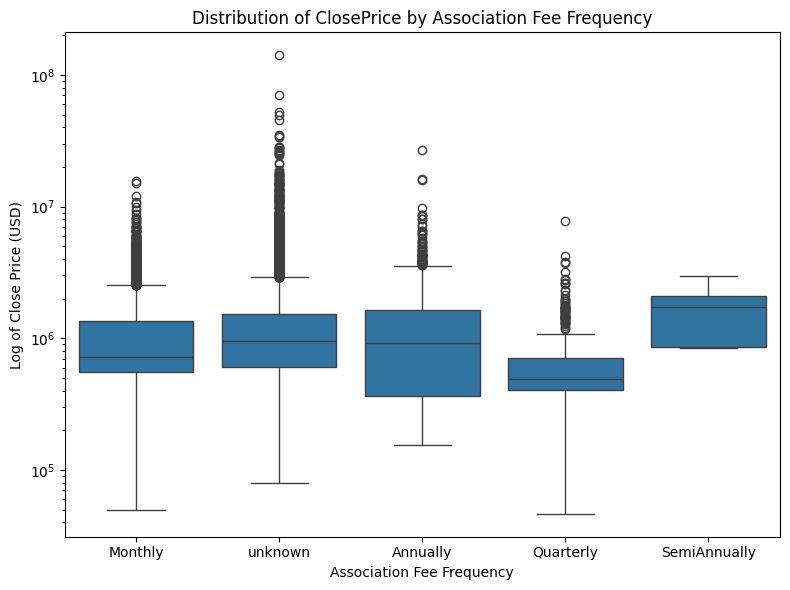

In [139]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='AssociationFeeFrequency', y='ClosePrice')
plt.yscale('log')
plt.title('Distribution of ClosePrice by Association Fee Frequency')
plt.xlabel('Association Fee Frequency')
plt.ylabel('Log of Close Price (USD)')
plt.tight_layout()
plt.show()

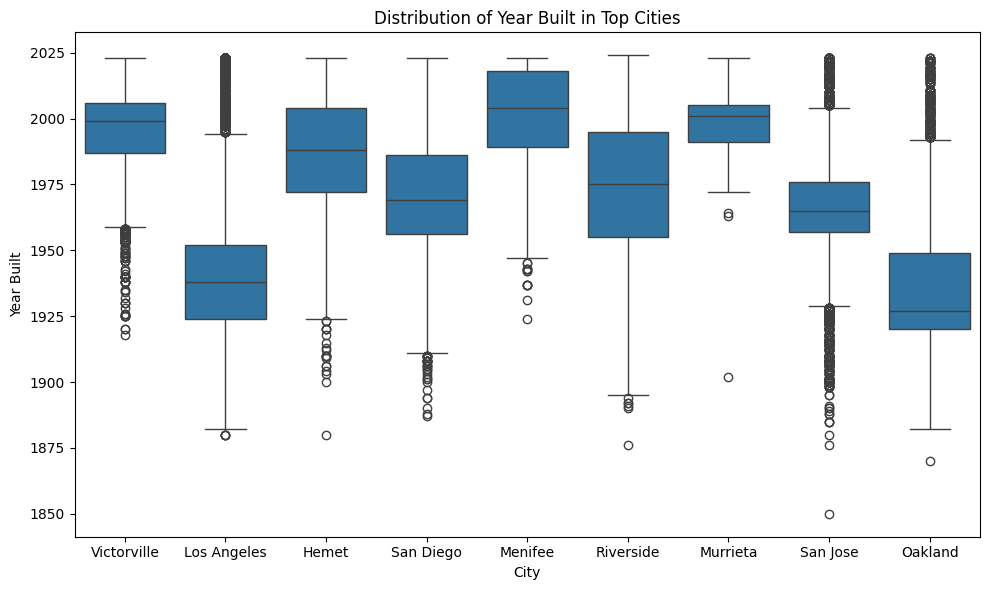

In [187]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='City', y='YearBuilt')
plt.title('Distribution of Year Built in Top Cities')
plt.ylabel('Year Built')
plt.xlabel('City')
plt.tight_layout()
plt.show()

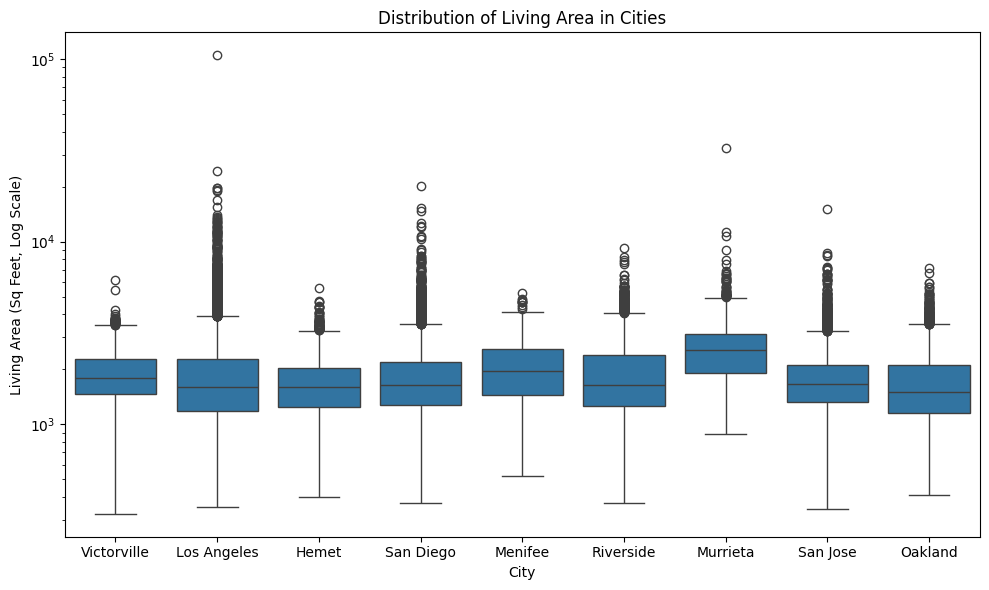

In [141]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='City', y='LivingArea')
plt.yscale('log')
plt.title('Distribution of Living Area in Cities')
plt.ylabel('Living Area (Sq Feet, Log Scale)')
plt.tight_layout()
plt.show()

In [143]:
df['City'].value_counts()

,count
City,
Los Angeles,10580
San Diego,9626
San Jose,7689
Riverside,4308
Oakland,3952
Menifee,3201
Victorville,3087
Hemet,2903
Murrieta,2441


In [144]:
# Filter data for 2022 and 2023
df_2022 = df[df['CloseDate'].dt.year == 2022]
df_2023 = df[df['CloseDate'].dt.year == 2023]

# Remove missing values in 'ClosePrice' for 2022 and 2023
df_2022_clean = df_2022['ClosePrice'].dropna()
df_2023_clean = df_2023['ClosePrice'].dropna()

# Calculate the mean and standard deviation for 2022 and 2023
mean_2022_clean = df_2022_clean.mean()
std_2022_clean = df_2022_clean.std()

mean_2023_clean = df_2023_clean.mean()
std_2023_clean = df_2023_clean.std()

# Create a dataframe to display the results
mean_std_comparison_clean = pd.DataFrame({
    'Year': ['2022', '2023'],
    'Mean ClosePrice': [mean_2022_clean, mean_2023_clean],
    'Std ClosePrice': [std_2022_clean, std_2023_clean]
})


In [145]:
mean_std_comparison_clean

,Year,Mean ClosePrice,Std ClosePrice
0,2022,1.223946e+06,1.571267e+06
1,2023,1.198718e+06,1.134819e+06


In [156]:
df.shape

(47787, 29)

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47787 entries, 0 to 50173
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Flooring                     28870 non-null  object        
 1   ViewYN                       47787 non-null  object        
 2   PoolPrivateYN                47787 non-null  object        
 3   CloseDate                    47787 non-null  datetime64[ns]
 4   ClosePrice                   47787 non-null  float64       
 5   Latitude                     47766 non-null  float64       
 6   Longitude                    47766 non-null  float64       
 7   LivingArea                   47731 non-null  float64       
 8   ListPrice                    47787 non-null  float64       
 9   DaysOnMarket                 47787 non-null  int64         
 10  AssociationFeeFrequency      47787 non-null  object        
 11  AttachedGarageYN             47787 non-null  o

In [158]:
columns_to_drop = ['CloseDate_Month', 'LogClosePrice']
df.drop(columns=columns_to_drop, inplace=True)

In [159]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 47787 entries, 0 to 50173
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Flooring                     28870 non-null  object        
 1   ViewYN                       47787 non-null  object        
 2   PoolPrivateYN                47787 non-null  object        
 3   CloseDate                    47787 non-null  datetime64[ns]
 4   ClosePrice                   47787 non-null  float64       
 5   Latitude                     47766 non-null  float64       
 6   Longitude                    47766 non-null  float64       
 7   LivingArea                   47731 non-null  float64       
 8   ListPrice                    47787 non-null  float64       
 9   DaysOnMarket                 47787 non-null  int64         
 10  AssociationFeeFrequency      47787 non-null  object        
 11  AttachedGarageYN             47787 non-null  o

In [160]:
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_data_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percentage
})
print(missing_data_df)

                             Missing Values  Percentage (%)
Flooring                              18917       39.586080
ViewYN                                    0        0.000000
PoolPrivateYN                             0        0.000000
CloseDate                                 0        0.000000
ClosePrice                                0        0.000000
Latitude                                 21        0.043945
Longitude                                21        0.043945
LivingArea                               56        0.117187
ListPrice                                 0        0.000000
DaysOnMarket                              0        0.000000
AssociationFeeFrequency                   0        0.000000
AttachedGarageYN                          0        0.000000
ParkingTotal                            907        1.898006
LotSizeAcres                           2118        4.432168
YearBuilt                                62        0.129742
BuyerAgencyCompensationType             

In [164]:
df['City'].value_counts()

,count
City,
Los Angeles,10580
San Diego,9626
San Jose,7689
Riverside,4308
Oakland,3952
Menifee,3201
Victorville,3087
Hemet,2903
Murrieta,2441


## Split Data

In [165]:
df_processed = df.copy()

In [166]:
X = df_processed.drop(columns=['ClosePrice'])
y = df_processed['ClosePrice']

In [167]:
# Split into test set and "train+val" set with stratification on 'City'
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=df_processed['City'], random_state=42)

In [168]:
# Feature Engineering on the "train+val" set
def feature_engineering(df):
    df = df.copy()

    # Encode 'Flooring'
    flooring = df['Flooring'].str.get_dummies(sep=',')
    flooring.columns = ['Flooring_' + col for col in flooring.columns]
    df = pd.concat([df, flooring], axis=1)
    df.drop('Flooring', axis=1, inplace=True)

    # Encode categorical columns
    categorical_columns = [
        'ViewYN', 'PoolPrivateYN', 'AssociationFeeFrequency',
        'AttachedGarageYN', 'BuyerAgencyCompensationType',
        'City', 'FireplaceYN', 'NewConstructionYN'
    ]
    prefix_dict = {
        'ViewYN': 'View',
        'PoolPrivateYN': 'Pool',
        'AssociationFeeFrequency': 'AssociationFeeFrequency',
        'AttachedGarageYN': 'AttachedGarage',
        'BuyerAgencyCompensationType': 'BuyerCompType',
        'City': 'City',
        'FireplaceYN': 'Fireplace',
        'NewConstructionYN': 'NewConstruction'
    }
    for col in categorical_columns:
        dummies = pd.get_dummies(df[col], prefix=prefix_dict[col]).astype(int)
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1, inplace=True)

    # Transform 'CloseDate' column
    df['CloseDate'] = pd.to_datetime(df['CloseDate'])
    df['Close_Year'] = df['CloseDate'].dt.year.map({2022: 0, 2023: 1})
    df['Close_Month'] = df['CloseDate'].dt.month
    month_dummies = pd.get_dummies(df['Close_Month'], prefix='Close_Month').astype(int)
    df = pd.concat([df, month_dummies], axis=1)
    df.drop(['CloseDate', 'Close_Month'], axis=1, inplace=True)

    # Encode 'Levels'
    levels_expanded = df['Levels'].str.get_dummies(sep=',')
    levels_expanded.columns = ['Levels_' + col for col in levels_expanded.columns]
    df = pd.concat([df, levels_expanded], axis=1)
    df.drop('Levels', axis=1, inplace=True)

    # Encode 'PostalCode'
    zipcode_dummies = pd.get_dummies(df['PostalCode'], prefix='Zipcode').astype(int)
    df = pd.concat([df, zipcode_dummies], axis=1)
    df.drop('PostalCode', axis=1, inplace=True)

    return df

# Apply feature engineering on "train+val" set
X_train_val_fe = feature_engineering(X_train_val)

# Apply feature engineering on the test set
X_test_fe = feature_engineering(X_test)
X_test_fe = X_test_fe.reindex(columns=X_train_val_fe.columns, fill_value=0)

# Standard Scaling and Min-Max Scaling
standard_features = [
    'LivingArea', 'ListPrice', 'DaysOnMarket',
    'ParkingTotal', 'LotSizeAcres', 'YearBuilt', 'BathroomsTotalInteger',
    'BedroomsTotal', 'Stories', 'MainLevelBedrooms', 'GarageSpaces',
    'AssociationFee'
]

minmax_features = ['Latitude', 'Longitude']

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Standard
X_train_val_fe[standard_features] = standard_scaler.fit_transform(X_train_val_fe[standard_features])
X_test_fe[standard_features] = standard_scaler.transform(X_test_fe[standard_features])

# Min-Max
X_train_val_fe[minmax_features] = minmax_scaler.fit_transform(X_train_val_fe[minmax_features])
X_test_fe[minmax_features] = minmax_scaler.transform(X_test_fe[minmax_features])

In [169]:
# KFold on the "train+val" set
kf = KFold(n_splits=5, shuffle=True, random_state=42)

folds = []
for train_idx, val_idx in kf.split(X_train_val_fe):
    X_train_fold, X_val_fold = X_train_val_fe.iloc[train_idx], X_train_val_fe.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

    folds.append({
        "Train Fold Size": len(train_idx),
        "Validation Fold Size": len(val_idx)
    })

folds_df = pd.DataFrame(folds)
print(folds_df)

shapes_info = {
    "Train+Validation Set Shape": X_train_val_fe.shape,
    "Test Set Shape": X_test_fe.shape
}
print(shapes_info)

   Train Fold Size  Validation Fold Size
0            30583                  7646
1            30583                  7646
2            30583                  7646
3            30583                  7646
4            30584                  7645
{'Train+Validation Set Shape': (38229, 298), 'Test Set Shape': (9558, 298)}


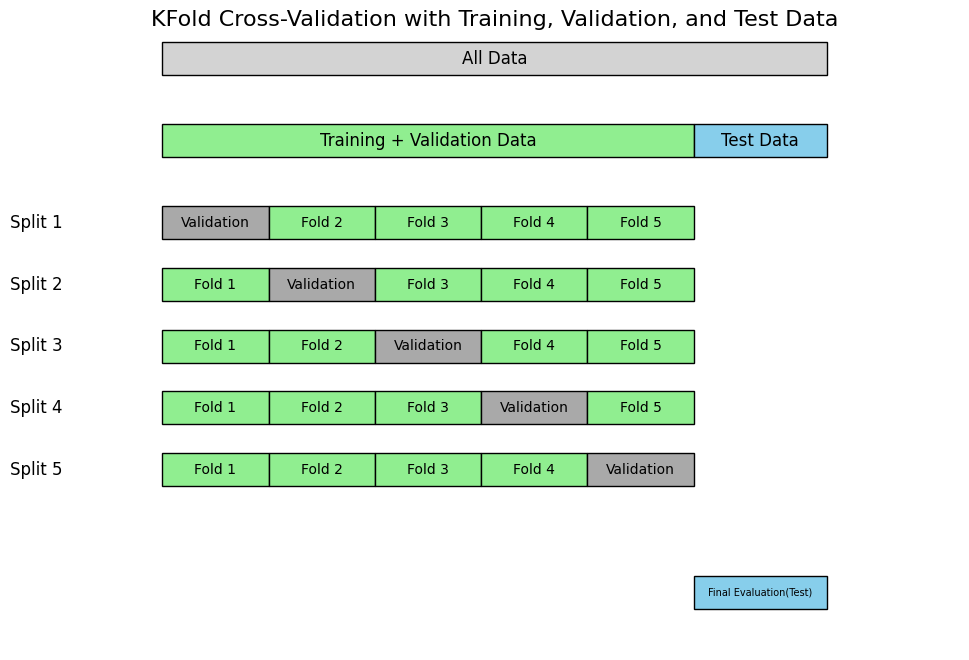

In [182]:
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(12, 8))

ax.add_patch(patches.Rectangle((0, 10), 10, 0.8, edgecolor='black', facecolor='lightgrey'))
ax.text(5, 10 + 0.8 / 2, 'All Data', ha='center', va='center', fontsize=12)

ax.add_patch(patches.Rectangle((0, 8), 8, 0.8, edgecolor='black', facecolor='lightgreen'))
ax.text(4, 8 + 0.8 / 2, 'Training + Validation Data', ha='center', va='center', fontsize=12)

ax.add_patch(patches.Rectangle((8, 8), 2, 0.8, edgecolor='black', facecolor='skyblue'))
ax.text(9, 8 + 0.8 / 2, 'Test Data', ha='center', va='center', fontsize=12)

num_folds = 5
rect_height = 0.8
spacing = 1.5
colors = ['darkgrey', 'lightgreen']

for i in range(num_folds):
    y_offset = 6 - i * spacing
    for j in range(num_folds):
        color = colors[0] if j == i else colors[1]
        ax.add_patch(patches.Rectangle((j * 1.6, y_offset), 1.6, rect_height, edgecolor='black', facecolor=color))
        label = 'Validation' if j == i else f'Fold {j + 1}'
        ax.text(j * 1.6 + 0.8, y_offset + rect_height / 2, label, ha='center', va='center', fontsize=10)
    ax.text(-1.5, y_offset + rect_height / 2, f'Split {i + 1}', ha='right', va='center', fontsize=12)

ax.add_patch(patches.Rectangle((8, -3), 2, rect_height, edgecolor='black', facecolor='skyblue'))
ax.text(9, -3 + rect_height / 2, 'Final Evaluation(Test)', ha='center', va='center', fontsize=7)

ax.set_xlim(-2, 12)
ax.set_ylim(-4, 11)
ax.axis('off')
plt.title('KFold Cross-Validation with Training, Validation, and Test Data', fontsize=16)
plt.show()


In [171]:
X_test_fe.head()

,Latitude,Longitude,LivingArea,ListPrice,DaysOnMarket,ParkingTotal,LotSizeAcres,YearBuilt,BathroomsTotalInteger,BedroomsTotal,...,Zipcode_95132,Zipcode_95133,Zipcode_95134,Zipcode_95135,Zipcode_95136,Zipcode_95138,Zipcode_95139,Zipcode_95140,Zipcode_95148,Zipcode_95602
918,0.274813,0.694426,-1.039929,-0.342781,9.920375,-0.070312,-0.187226,-1.983150,-1.330537,-1.424808,...,0,0,0,0,0,0,0,0,0,0
15771,0.224257,0.916538,-0.736112,-0.386432,-0.127097,-0.070312,-0.057203,-0.111182,-0.426817,-1.424808,...,0,0,0,0,0,0,0,0,0,0
18593,0.028758,0.900465,-0.394095,-0.200349,1.167681,-0.070312,-0.030097,0.713753,-0.426817,0.593197,...,0,0,0,0,0,0,0,0,0,0
20210,0.264395,0.685153,1.101005,-0.236684,-0.489634,-0.259782,-0.088629,-0.904389,1.380623,1.602200,...,0,0,0,0,0,0,0,0,0,0
8718,0.902406,0.075723,-0.422523,-0.158685,1.115889,-0.070312,-0.121579,0.491655,0.476903,0.593197,...,0,0,0,0,0,0,0,0,0,0
